#**Analysis of CNN Models, LLM's, and Prompt Engineering Techniques**

In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install statsmodels pingouin --quiet
!pip install MLstatkit --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.4/204.4 kB 5.1 MB/s eta 0:00:00


In [3]:
# Imports
import os
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import math
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


import itertools
from itertools import combinations

from sklearn.metrics import (
    accuracy_score, brier_score_loss, confusion_matrix, classification_report, average_precision_score,
    matthews_corrcoef, precision_score, roc_curve, auc, precision_recall_curve, roc_auc_score
)
from sklearn.utils import resample
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.calibration import calibration_curve, CalibratedClassifierCV, IsotonicRegression


from scipy import stats
import scipy.stats as st
from scipy.stats import friedmanchisquare, chi2

import statsmodels.api as sm

import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator


from statsmodels.stats.contingency_tables import mcnemar, Table2x2
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.proportion import proportion_confint

from MLstatkit.stats import Delong_test

import pingouin as pg

import ast

import plotly.graph_objects as go


/tmp/ipython-input-299391713.py:41: UserWarning: Importing from MLstatkit.stats is deprecated and will be removed in v0.2.0. Please use `from MLstatkit import ...` instead.
  from MLstatkit.stats import Delong_test


# Loading

In [4]:
# Load Models & History
IMG_HEIGHT, IMG_WIDTH = 128, 128
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
BATCH_SIZE = 32
CLASSES = ["Impact", "Volcanic"]

BASE_PATH = "/content/drive/MyDrive/Dissertation/FinalDataset"
TRAIN_PATH, VAL_PATH, TEST_PATH = [os.path.join(BASE_PATH, folder) for folder in ["train", "val", "test"]]

MODEL_PATHS = [
    "/content/drive/MyDrive/Dissertation/Models/EXP_001.h5",
    "/content/drive/MyDrive/Dissertation/Models/EXP_002.h5",
    "/content/drive/MyDrive/Dissertation/Models/EXP_003.h5",
    "/content/drive/MyDrive/Dissertation/Models/EXP_004.h5",
    "/content/drive/MyDrive/Dissertation/Models/EXP_005.h5",
    "/content/drive/MyDrive/Dissertation/Models/EXP_006.h5",
    "/content/drive/MyDrive/Dissertation/Models/EXP_007.h5",
    "/content/drive/MyDrive/Dissertation/Models/EXP_008.h5",
]


models = [load_model(path) for path in MODEL_PATHS]
model_names = [os.path.splitext(os.path.basename(path))[0] for path in MODEL_PATHS]
print(model_names)


HISTORY_PATHS = [
    "/content/drive/MyDrive/Dissertation/Models/EXP_001_history.pkl",
    "/content/drive/MyDrive/Dissertation/Models/EXP_002_history.pkl",
    "/content/drive/MyDrive/Dissertation/Models/EXP_003_history.pkl",
    "/content/drive/MyDrive/Dissertation/Models/EXP_004_history.pkl",
    "/content/drive/MyDrive/Dissertation/Models/EXP_005_history.pkl",
    "/content/drive/MyDrive/Dissertation/Models/EXP_006_history.pkl",
    "/content/drive/MyDrive/Dissertation/Models/EXP_007_history.pkl",
    "/content/drive/MyDrive/Dissertation/Models/EXP_008_history.pkl",
]

history = []
history_names = []

for path in HISTORY_PATHS:
    with open(path, "rb") as f:
        hist_dict = pickle.load(f)
        history.append(hist_dict)
        history_names.append(os.path.splitext(os.path.basename(path))[0])

print(history_names)
print(history[0].keys())


['EXP_001', 'EXP_002', 'EXP_003', 'EXP_004', 'EXP_005', 'EXP_006', 'EXP_007', 'EXP_008']
['EXP_001_history', 'EXP_002_history', 'EXP_003_history', 'EXP_004_history', 'EXP_005_history', 'EXP_006_history', 'EXP_007_history', 'EXP_008_history']
dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


In [5]:
datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    TRAIN_PATH, target_size=IMG_SIZE, color_mode="grayscale",
    class_mode="binary", batch_size=BATCH_SIZE, shuffle=True
)

val_gen = datagen.flow_from_directory(
    VAL_PATH, target_size=IMG_SIZE, color_mode="grayscale",
    class_mode="binary", batch_size=BATCH_SIZE, shuffle=False
)

test_gen = datagen.flow_from_directory(
    TEST_PATH, target_size=IMG_SIZE, color_mode="grayscale",
    class_mode="binary", batch_size=BATCH_SIZE, shuffle=False
)

Found 2400 images belonging to 2 classes.
Found 300 images belonging to 2 classes.
Found 300 images belonging to 2 classes.


In [6]:
df = pd.read_csv("/content/drive/MyDrive/Dissertation/df.csv")
df

experiment_id prompt_style llm_company      llm_version        class
0       EXP_001      minimal      openai        chatgpt_4       binary
1       EXP_002          cot      openai        chatgpt_4       binary
2       EXP_003         scot      openai        chatgpt_4       binary
3       EXP_004         role      openai        chatgpt_4       binary
4       EXP_005      minimal   anthropic  claude_sonnet_4  categorical
5       EXP_006          cot   anthropic  claude_sonnet_4       binary
6       EXP_007         scot   anthropic  claude_sonnet_4       binary
7       EXP_008         role   anthropic  claude_sonnet_4       binary

In [7]:
df['llm_company'] = df['llm_company'].replace({
    'openai': 'ChatGPT',
    'anthropic': 'Claude'
})


#Mappings

In [8]:
# Constants & Mappings

FACTOR_MAP = {
    "EXP_001": ("ChatGPT", "Minimal"),
    "EXP_002": ("ChatGPT", "CoT"),
    "EXP_003": ("ChatGPT", "sCoT"),
    "EXP_004": ("ChatGPT", "Role"),
    "EXP_005": ("Claude",  "Minimal"),
    "EXP_006": ("Claude",  "CoT"),
    "EXP_007": ("Claude",  "sCoT"),
    "EXP_008": ("Claude",  "Role"),
}

CHATGPT_MODELS = [exp for exp, (llm, _) in FACTOR_MAP.items() if llm == "ChatGPT"]
CLAUDE_MODELS  = [exp for exp, (llm, _) in FACTOR_MAP.items() if llm == "Claude"]

PROMPTS = ["Minimal", "CoT", "sCoT", "Role"]

LLM_COLORS = {"ChatGPT": "#ff66cc", "Claude":  "#0CAFFF"}

df["LLM"]    = df["experiment_id"].map(lambda x: FACTOR_MAP[x][0])
df["Prompt"] = df["experiment_id"].map(lambda x: FACTOR_MAP[x][1])



# Training, Validation, and Test Accuracy and Loss

In [9]:
# Training Accuracy & Loss

print("Training Accuracy & Loss")
train_metrics = {}

for name, hist in zip(history_names, history):
    train_acc = max(hist['accuracy'])
    train_loss = min(hist['loss'])
    print(f"{name} | Training Accuracy: {train_acc:.4f}, Training Loss: {train_loss:.4f}")
    train_metrics[name] = {'train_acc': train_acc, 'train_loss': train_loss}

df['train_accuracy'] = df['experiment_id'].map(
    lambda x: max(history[history_names.index(f"{x}_history")]['accuracy'])
)
df['train_loss'] = df['experiment_id'].map(
    lambda x: min(history[history_names.index(f"{x}_history")]['loss'])
)

Training Accuracy & Loss
EXP_001_history | Training Accuracy: 0.9837, Training Loss: 0.0526
EXP_002_history | Training Accuracy: 0.9887, Training Loss: 0.0318
EXP_003_history | Training Accuracy: 0.9200, Training Loss: 0.2123
EXP_004_history | Training Accuracy: 0.9417, Training Loss: 0.1685
EXP_005_history | Training Accuracy: 0.8469, Training Loss: 0.3711
EXP_006_history | Training Accuracy: 0.9617, Training Loss: 0.1131
EXP_007_history | Training Accuracy: 0.9629, Training Loss: 0.1115
EXP_008_history | Training Accuracy: 0.9871, Training Loss: 0.0404


In [10]:
# Val Accuracy & Loss
print("Validation Accuracy & Loss")
val_metrics = {}

for name, hist in zip(model_names, history):
    val_acc = max(hist['val_accuracy'])
    val_loss = min(hist['val_loss'])
    print(f"{name} | Validation Accuracy: {val_acc:.4f}, Validation Loss: {val_loss:.4f}")
    val_metrics[name] = {'val_acc': val_acc, 'val_loss': val_loss}


df['val_accuracy'] = df['experiment_id'].map(
    lambda x: max(history[history_names.index(f"{x}_history")]['val_accuracy'])
)
df['val_loss'] = df['experiment_id'].map(
    lambda x: min(history[history_names.index(f"{x}_history")]['val_loss'])
)


Validation Accuracy & Loss
EXP_001 | Validation Accuracy: 0.8933, Validation Loss: 0.3042
EXP_002 | Validation Accuracy: 0.9000, Validation Loss: 0.3260
EXP_003 | Validation Accuracy: 0.8667, Validation Loss: 0.3194
EXP_004 | Validation Accuracy: 0.9533, Validation Loss: 0.1544
EXP_005 | Validation Accuracy: 0.5188, Validation Loss: 1.3948
EXP_006 | Validation Accuracy: 0.9722, Validation Loss: 0.0799
EXP_007 | Validation Accuracy: 0.9833, Validation Loss: 0.0638
EXP_008 | Validation Accuracy: 1.0000, Validation Loss: 0.0065


In [11]:
# Test Accuracy & Loss
# NOTE: EXP_005 is CAT
categorical_models = {"EXP_005"}

results = {}
for name, model, hist in zip(model_names, models, history):
    is_categorical = name in categorical_models
    val_acc = max(hist['val_accuracy'])
    val_loss = min(hist['val_loss'])
    test_steps = test_gen.samples // test_gen.batch_size + (test_gen.samples % test_gen.batch_size > 0)
    y_true = test_gen.classes
    y_pred_prob = model.predict(test_gen, steps=test_steps, verbose=0)
    if is_categorical:
        y_pred = np.argmax(y_pred_prob, axis=1)
        test_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred_prob).numpy().mean()
        y_score = y_pred_prob[:, 1]
    else:
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()
        test_loss = tf.keras.losses.binary_crossentropy(y_true, y_pred_prob.flatten()).numpy().mean()
        y_score = y_pred_prob.flatten()
    acc = np.mean(y_true == y_pred)
    print(f"{name} (Categorical: {is_categorical}) | Test Accuracy: {acc:.4f}, Test Loss: {test_loss:.4f}")

    results[name] = {
        "test_acc": acc,
        "test_loss": test_loss,
        "y_true": y_true,
        "y_pred": y_pred,
        "y_score": y_score
    }

df['test_accuracy'] = df['experiment_id'].map(lambda x: results[x]['test_acc'])
df['test_loss']     = df['experiment_id'].map(lambda x: results[x]['test_loss'])
df['y_true']        = df['experiment_id'].map(lambda x: results[x]['y_true'])
df['y_pred']        = df['experiment_id'].map(lambda x: results[x]['y_pred'])
df['y_score']       = df['experiment_id'].map(lambda x: results[x]['y_score'])

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


EXP_001 (Categorical: False) | Test Accuracy: 0.8967, Test Loss: 0.2623
EXP_002 (Categorical: False) | Test Accuracy: 0.9000, Test Loss: 0.2932
EXP_003 (Categorical: False) | Test Accuracy: 0.8733, Test Loss: 0.3016
EXP_004 (Categorical: False) | Test Accuracy: 0.9067, Test Loss: 0.2420
EXP_005 (Categorical: True) | Test Accuracy: 0.5000, Test Loss: 1.3945
EXP_006 (Categorical: False) | Test Accuracy: 0.9500, Test Loss: 0.1148
EXP_007 (Categorical: False) | Test Accuracy: 0.9667, Test Loss: 0.0996
EXP_008 (Categorical: False) | Test Accuracy: 0.9900, Test Loss: 0.0265


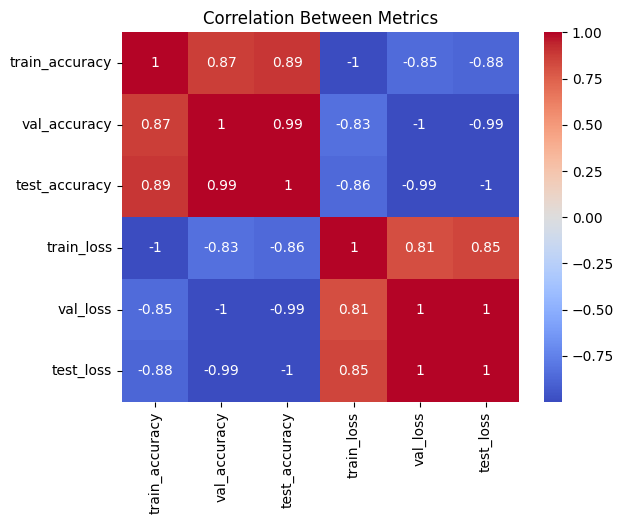

In [12]:
# Heatmap
sns.heatmap(df[['train_accuracy','val_accuracy','test_accuracy','train_loss','val_loss','test_loss']].corr(),
            annot=True, cmap='coolwarm', center=0)
plt.title("Correlation Between Metrics")
plt.show()

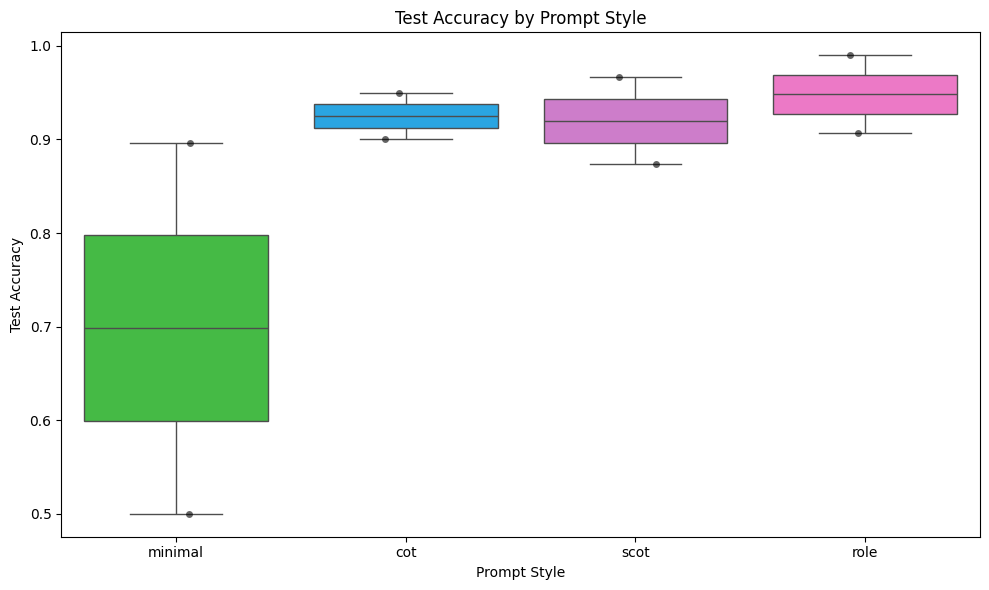

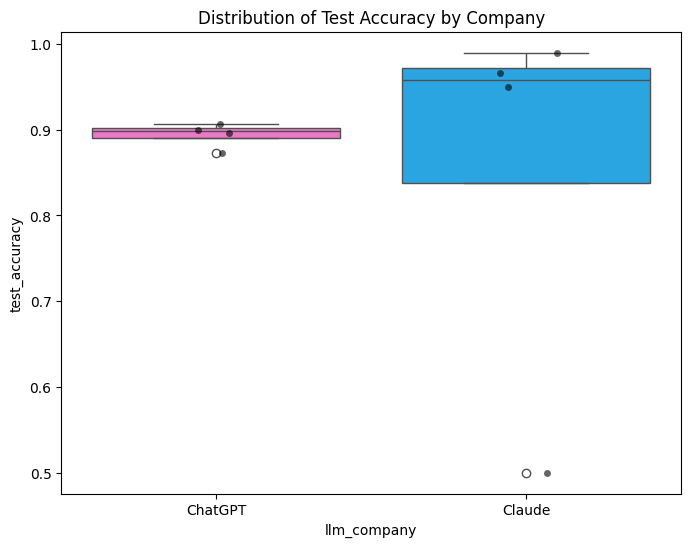

In [13]:
# Test Accuracy by prompt style
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='prompt_style', y='test_accuracy', hue='prompt_style', palette={'minimal':'#32cd32', 'cot':'#0CAFFF', 'scot':'#DA70D6', 'role':'#ff66cc'})
sns.stripplot(data=df, x='prompt_style', y='test_accuracy', color='black', alpha=0.6)
plt.title("Test Accuracy by Prompt Style")
plt.xlabel("Prompt Style")
plt.ylabel("Test Accuracy")
plt.tight_layout()
plt.show()

# Distribution of Test Accuracy by Company
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="llm_company", y="test_accuracy", hue='LLM', palette=LLM_COLORS)
sns.stripplot(data=df, x="llm_company", y="test_accuracy", color="black", alpha=0.6)
plt.title("Distribution of Test Accuracy by Company")
plt.show()

# Confusion Matrices

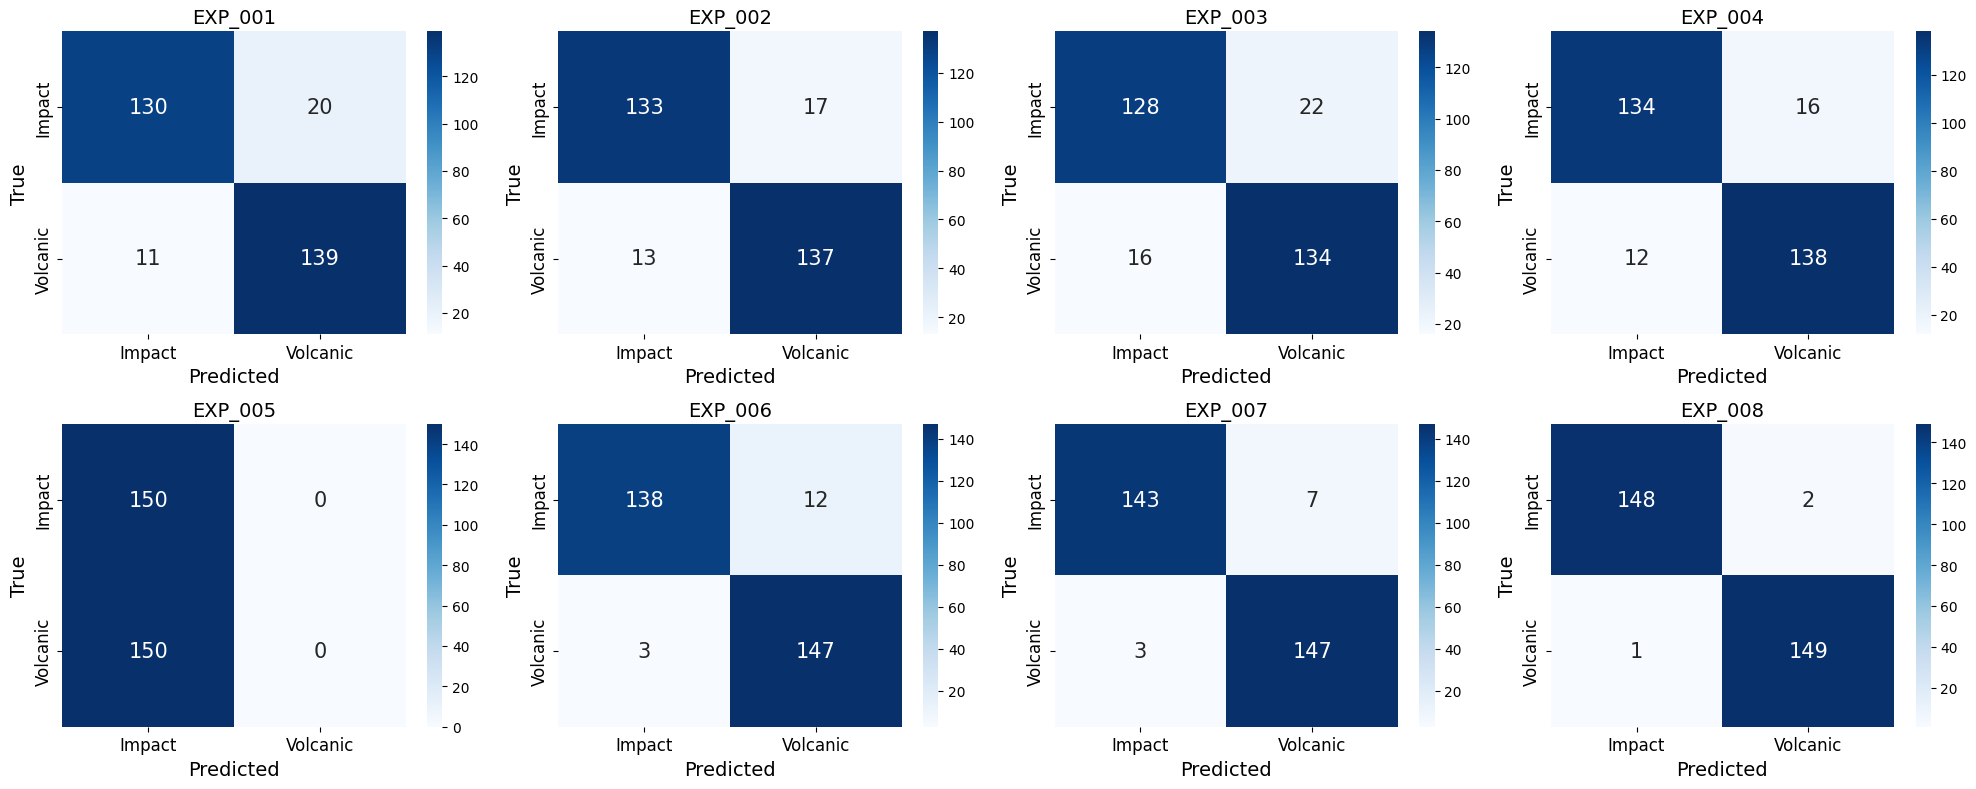

In [14]:
# Confusion Matrices
class_labels = ['Impact', 'Volcanic']

n_experiments = len(results)
cols = 4
rows = math.ceil(n_experiments / cols)

plt.figure(figsize=(cols*5, rows*4))

for i, (name, res) in enumerate(results.items(), 1):
    y_true = res['y_true']
    y_pred = res['y_pred']
    cm = confusion_matrix(y_true, y_pred)

    plt.subplot(rows, cols, i)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_labels,
        yticklabels=class_labels,
        annot_kws={"fontsize": 15}
    )

    plt.title(name, fontsize=14)
    plt.xlabel('Predicted', fontsize=14)
    plt.ylabel('True', fontsize=14)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()



# Classification Report

In [15]:
# Classification Reports
class_reports = {}

df['f1_score'] = None

for name, model in zip(model_names, models):
    y_true = test_gen.classes
    y_score = model.predict(test_gen, verbose=0)
    if y_score.shape[1] == 2:
        y_pred = np.argmax(y_score, axis=1)
    else:
        y_pred = (y_score > 0.5).astype(int).flatten()

    cr_dict = classification_report(y_true, y_pred, output_dict=True)
    cr_df = pd.DataFrame(cr_dict).transpose()

    f1_macro = cr_dict['macro avg']['f1-score']
    df.loc[df['experiment_id'] == name, 'f1_score'] = f1_macro

    class_reports[name] = cr_df
    print(f"\n Classification Report: {name}")
    display(cr_df)


 Classification Report: EXP_001


precision    recall  f1-score     support
0              0.921986  0.866667  0.893471  150.000000
1              0.874214  0.926667  0.899676  150.000000
accuracy       0.896667  0.896667  0.896667    0.896667
macro avg      0.898100  0.896667  0.896574  300.000000
weighted avg   0.898100  0.896667  0.896574  300.000000


 Classification Report: EXP_002


precision    recall  f1-score  support
0              0.910959  0.886667  0.898649    150.0
1              0.889610  0.913333  0.901316    150.0
accuracy       0.900000  0.900000  0.900000      0.9
macro avg      0.900285  0.900000  0.899982    300.0
weighted avg   0.900285  0.900000  0.899982    300.0


 Classification Report: EXP_003


precision    recall  f1-score     support
0              0.888889  0.853333  0.870748  150.000000
1              0.858974  0.893333  0.875817  150.000000
accuracy       0.873333  0.873333  0.873333    0.873333
macro avg      0.873932  0.873333  0.873283  300.000000
weighted avg   0.873932  0.873333  0.873283  300.000000


 Classification Report: EXP_004


precision    recall  f1-score     support
0              0.917808  0.893333  0.905405  150.000000
1              0.896104  0.920000  0.907895  150.000000
accuracy       0.906667  0.906667  0.906667    0.906667
macro avg      0.906956  0.906667  0.906650  300.000000
weighted avg   0.906956  0.906667  0.906650  300.000000


 Classification Report: EXP_005


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


precision  recall  f1-score  support
0                  0.50     1.0  0.666667    150.0
1                  0.00     0.0  0.000000    150.0
accuracy           0.50     0.5  0.500000      0.5
macro avg          0.25     0.5  0.333333    300.0
weighted avg       0.25     0.5  0.333333    300.0


 Classification Report: EXP_006


precision  recall  f1-score  support
0              0.978723    0.92  0.948454   150.00
1              0.924528    0.98  0.951456   150.00
accuracy       0.950000    0.95  0.950000     0.95
macro avg      0.951626    0.95  0.949955   300.00
weighted avg   0.951626    0.95  0.949955   300.00


 Classification Report: EXP_007


precision    recall  f1-score     support
0              0.979452  0.953333  0.966216  150.000000
1              0.954545  0.980000  0.967105  150.000000
accuracy       0.966667  0.966667  0.966667    0.966667
macro avg      0.966999  0.966667  0.966661  300.000000
weighted avg   0.966999  0.966667  0.966661  300.000000


 Classification Report: EXP_008


precision    recall  f1-score  support
0              0.993289  0.986667  0.989967   150.00
1              0.986755  0.993333  0.990033   150.00
accuracy       0.990000  0.990000  0.990000     0.99
macro avg      0.990022  0.990000  0.990000   300.00
weighted avg   0.990022  0.990000  0.990000   300.00

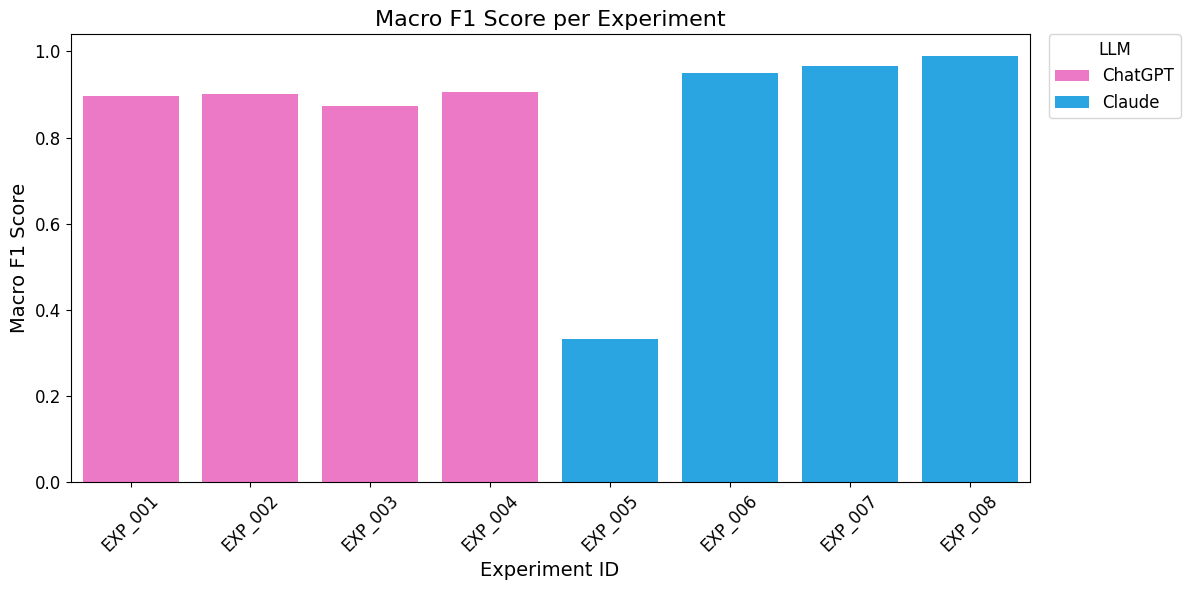

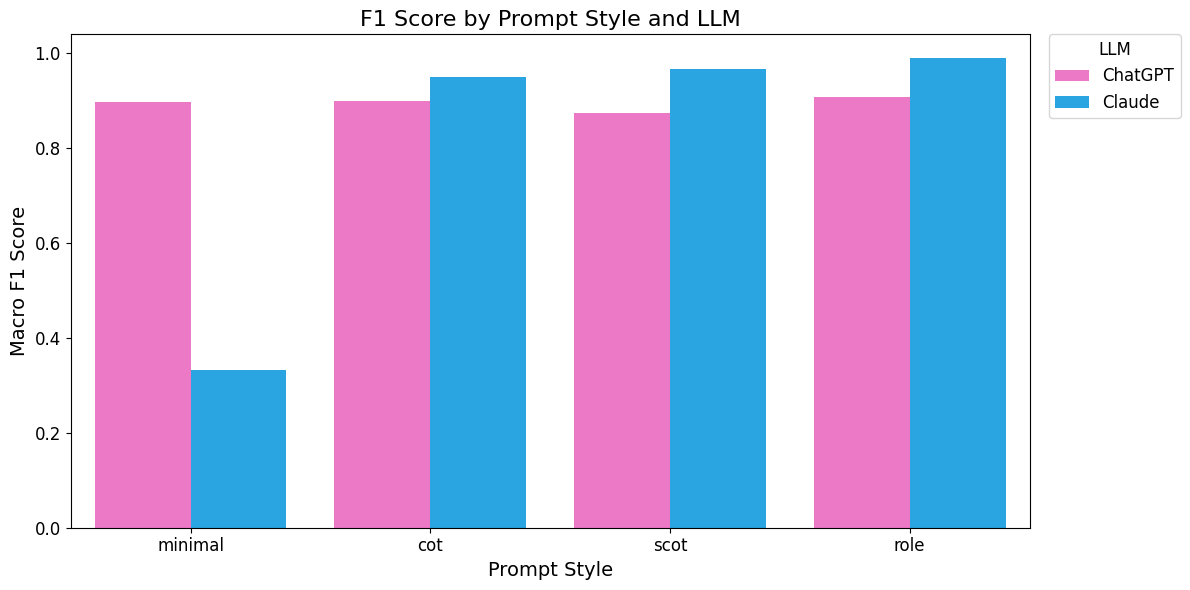

In [16]:
# Macro F1 Score per Experiment
plt.figure(figsize=(12,6))

sns.barplot(
    x='experiment_id',
    y='f1_score',
    hue='llm_company',
    data=df,
    palette=LLM_COLORS
)

plt.xlabel("Experiment ID", fontsize=14)
plt.ylabel("Macro F1 Score", fontsize=14)
plt.title("Macro F1 Score per Experiment", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="LLM", fontsize=12, title_fontsize=12, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

# F1 Score by Prompt Style and LLM


plt.figure(figsize=(12,6))

sns.barplot(
    x='prompt_style',
    y='f1_score',
    hue='llm_company',
    data=df,
    palette=LLM_COLORS
)
plt.xlabel("Prompt Style", fontsize=14)
plt.ylabel("Macro F1 Score", fontsize=14)
plt.title("F1 Score by Prompt Style and LLM", fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(title="LLM", fontsize=12, title_fontsize=12, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()



# Per-Class Correct Counts

In [17]:
# Per-class correct counts
class_labels = ['Impact', 'Volcanic']

for name, res in results.items():
    y_true = np.asarray(res['y_true'])
    y_pred = np.asarray(res['y_pred'])

    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    per_class_correct = np.diag(cm)
    per_class_total   = cm.sum(axis=1)
    per_class_acc     = per_class_correct / np.maximum(per_class_total, 1)

    res.update({
        'cm': cm,
        'per_class_correct': per_class_correct,
        'per_class_total': per_class_total,
        'per_class_acc': per_class_acc
    })

df['impact_acc']   = df['experiment_id'].map(lambda x: results[x]['per_class_acc'][0])
df['volcanic_acc'] = df['experiment_id'].map(lambda x: results[x]['per_class_acc'][1])

print("Per-Class Correct Counts")
for name, res in results.items():
    corr = res['per_class_correct']
    tot  = res['per_class_total']
    acc  = res['per_class_acc']
    print(
        f"{name} | "
        f"Impact: {int(corr[0])}/{int(tot[0])} ({acc[0]:.3f}) | "
        f"Volcanic: {int(corr[1])}/{int(tot[1])} ({acc[1]:.3f})"
    )


Per-Class Correct Counts
EXP_001 | Impact: 130/150 (0.867) | Volcanic: 139/150 (0.927)
EXP_002 | Impact: 133/150 (0.887) | Volcanic: 137/150 (0.913)
EXP_003 | Impact: 128/150 (0.853) | Volcanic: 134/150 (0.893)
EXP_004 | Impact: 134/150 (0.893) | Volcanic: 138/150 (0.920)
EXP_005 | Impact: 150/150 (1.000) | Volcanic: 0/150 (0.000)
EXP_006 | Impact: 138/150 (0.920) | Volcanic: 147/150 (0.980)
EXP_007 | Impact: 143/150 (0.953) | Volcanic: 147/150 (0.980)
EXP_008 | Impact: 148/150 (0.987) | Volcanic: 149/150 (0.993)


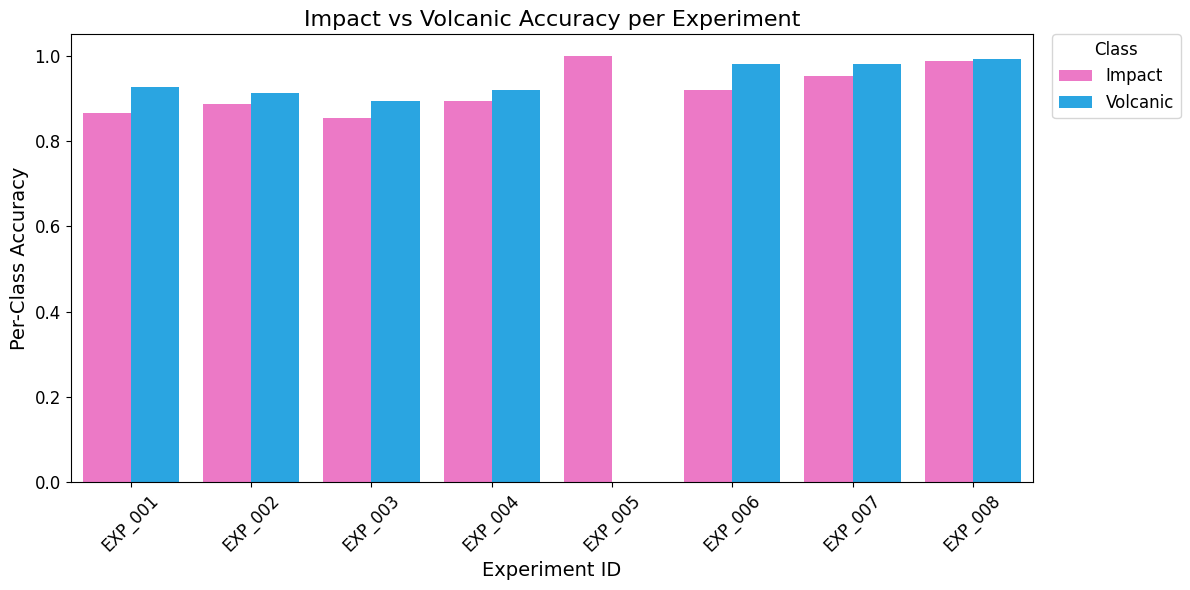

In [18]:
# Impact vs Volcanic Accuracy per Experiment


plt.figure(figsize=(12,6))

# Create a tidy dataframe for plotting
df_long = pd.melt(
    df,
    id_vars=['experiment_id'],
    value_vars=['impact_acc', 'volcanic_acc'],
    var_name='class',
    value_name='accuracy'
)

df_long['class'] = df_long['class'].map({
    'impact_acc': 'Impact',
    'volcanic_acc': 'Volcanic'
})
# Format graph
CLASS_COLORS = {
    'Impact': '#ff66cc',
    'Volcanic': '#0CAFFF'
}

sns.barplot(
    x='experiment_id',
    y='accuracy',
    hue='class',
    data=df_long,
    palette=CLASS_COLORS
)

plt.xlabel("Experiment ID", fontsize=14)
plt.ylabel("Per-Class Accuracy", fontsize=14)
plt.title("Impact vs Volcanic Accuracy per Experiment", fontsize=16)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

plt.legend(
    title="Class",
    fontsize=12,
    title_fontsize=12,
    bbox_to_anchor=(1.02, 1),
    loc='upper left',
    borderaxespad=0
)

plt.tight_layout()
plt.show()


# Matthews Correlation Coefficient (MCC)

Matthews Correlation Coefficient (MCC)
EXP_001 | MCC: 0.7948
EXP_002 | MCC: 0.8003
EXP_003 | MCC: 0.7473
EXP_004 | MCC: 0.8136
EXP_005 | MCC: 0.0000
EXP_006 | MCC: 0.9016
EXP_007 | MCC: 0.9337
EXP_008 | MCC: 0.9800


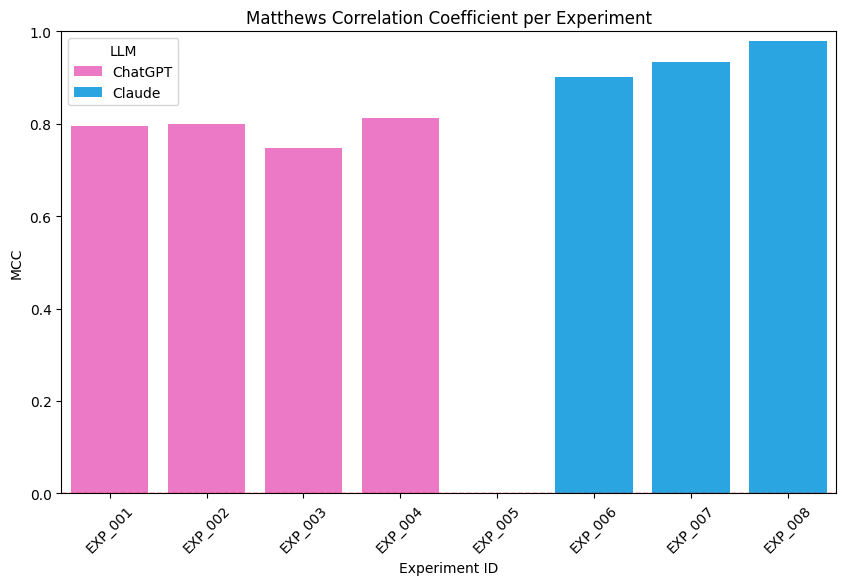

In [19]:
# MMC
print("Matthews Correlation Coefficient (MCC)")
mcc_scores = {}
for name, res in results.items():
    y_true = res['y_true']
    y_pred = res['y_pred']
    mcc = matthews_corrcoef(y_true, y_pred)
    mcc_scores[name] = mcc
    print(f"{name} | MCC: {mcc:.4f}")

df['mcc'] = df['experiment_id'].map(lambda x: mcc_scores[x])

# MMC per experiment
plt.figure(figsize=(10,6))
sns.barplot(
    x='experiment_id',
    y='mcc',
    data=df,
    hue='LLM',
    palette=LLM_COLORS,
    dodge=False
)

plt.ylim(0, 1)
plt.axhline(0, color='red', linestyle='--', linewidth=1)
plt.xticks(rotation=45)
plt.title('Matthews Correlation Coefficient per Experiment')
plt.ylabel('MCC')
plt.xlabel('Experiment ID')
plt.legend(title="LLM")
plt.show()


# ROC Curve & AUC

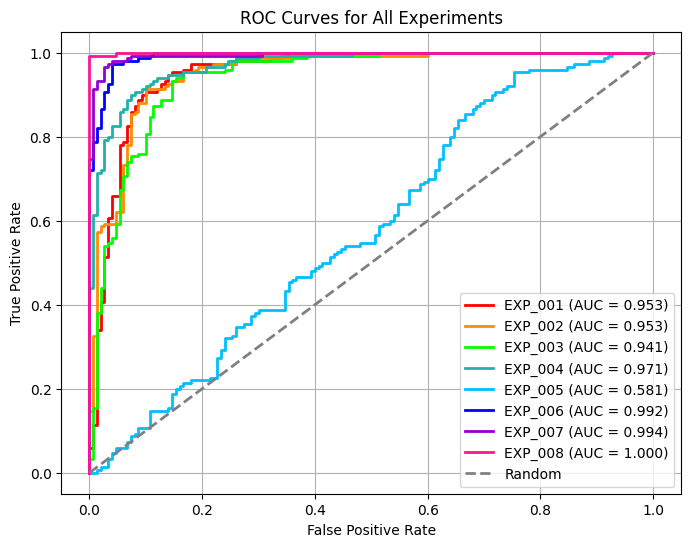

In [20]:

# ROC Curves
plt.figure(figsize=(8,6))
colors = itertools.cycle(['red', 'darkorange', 'lime', 'lightseagreen', 'deepskyblue', 'blue', 'darkviolet', 'deeppink'])

for name, res in results.items():
    y_true = np.array(res['y_true'])
    y_score = np.array(res['y_score'])
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    res['roc_auc'] = roc_auc
    df.loc[df['experiment_id'] == name, 'roc_auc'] = roc_auc

    plt.plot(fpr, tpr, color=next(colors), lw=2,
             label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0,1],[0,1], color='grey', lw=2, linestyle='--', label='Random')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Experiments')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# Precision-Recall Curve

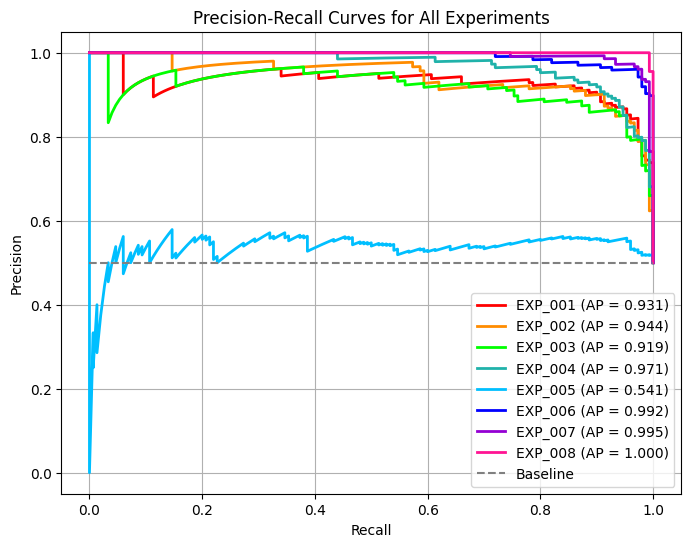

In [21]:
# PR Curves

plt.figure(figsize=(8,6))
colors = itertools.cycle(['red', 'darkorange', 'lime', 'lightseagreen', 'deepskyblue', 'blue', 'darkviolet', 'deeppink'])

for name, res in results.items():
    y_true = np.array(res['y_true'])
    y_score = np.array(res['y_score'])
    precision, recall, _ = precision_recall_curve(y_true, y_score)
    avg_prec = average_precision_score(y_true, y_score)

    res['avg_precision'] = avg_prec
    df.loc[df['experiment_id'] == name, 'avg_precision'] = avg_prec

    plt.plot(recall, precision, color=next(colors), lw=2,
             label=f"{name} (AP = {avg_prec:.3f})")

pos_ratio = np.mean(np.array(res['y_true']))
plt.hlines(pos_ratio, 0, 1, colors='grey', linestyles='--', label='Baseline')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves for All Experiments')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# Accuracy and Loss curves

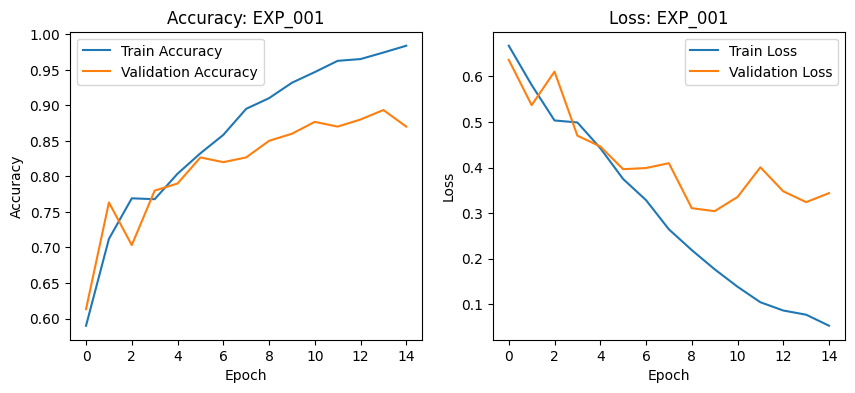

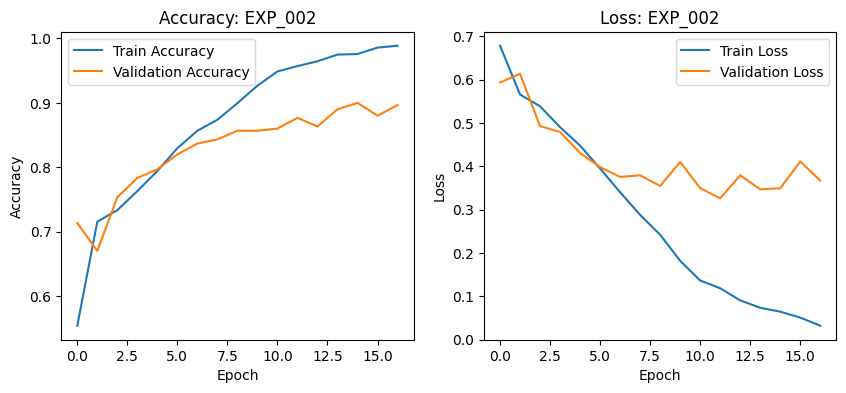

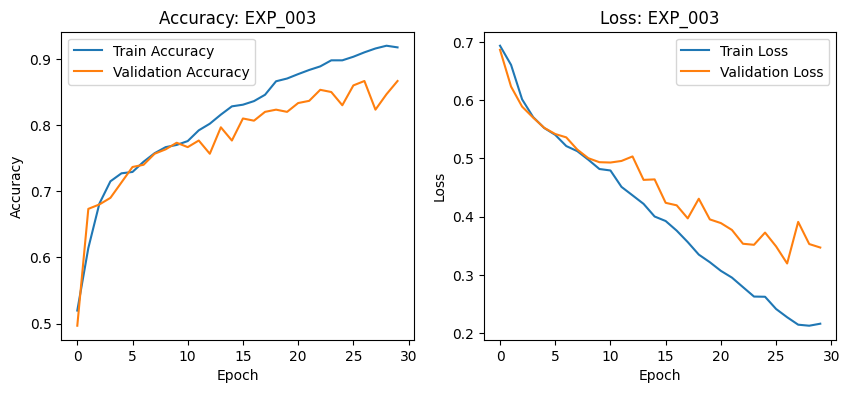

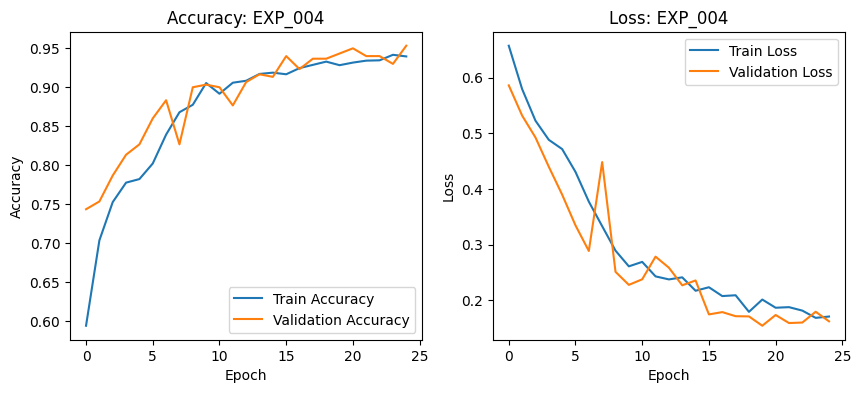

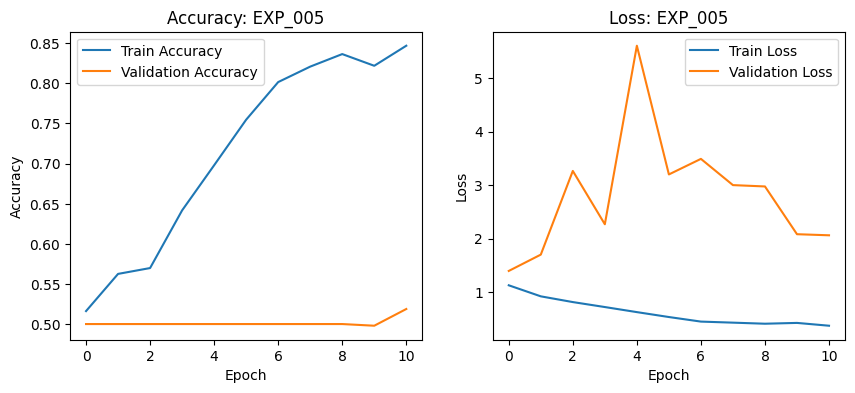

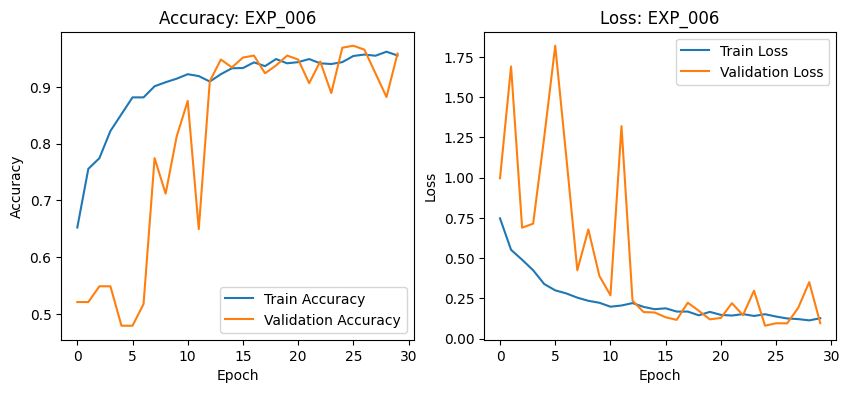

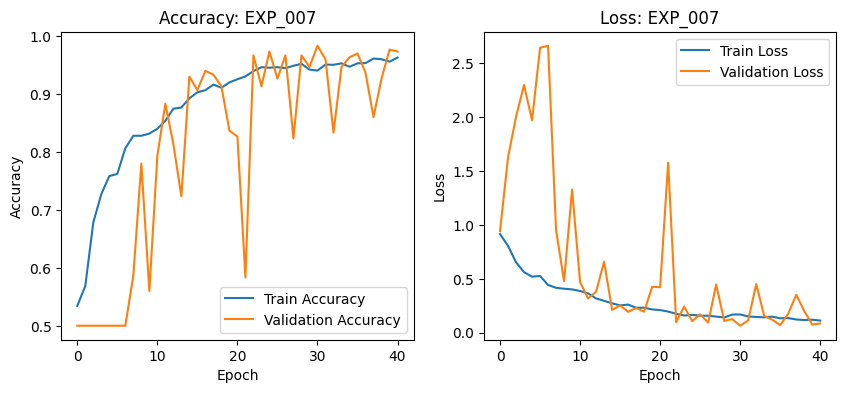

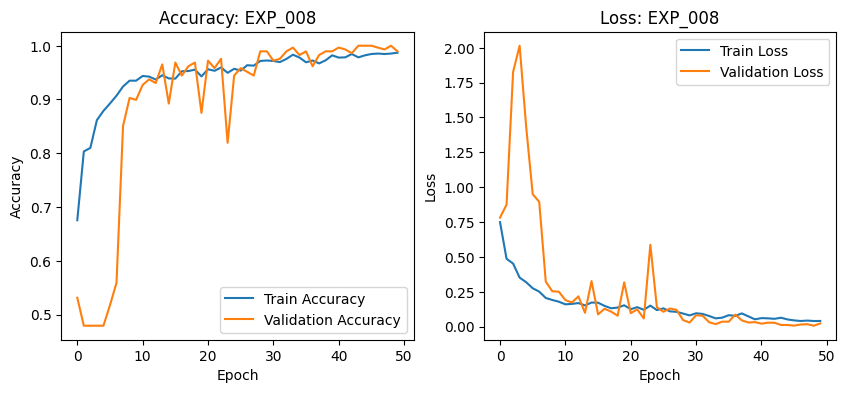

In [22]:
for name, hist in zip(model_names, history):
    plt.figure(figsize=(10,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(hist['accuracy'], label='Train Accuracy')
    plt.plot(hist.get('val_accuracy', []), label='Validation Accuracy')
    plt.title(f'Accuracy: {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(hist['loss'], label='Train Loss')
    plt.plot(hist.get('val_loss', []), label='Validation Loss')
    plt.title(f'Loss: {name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Integrated Gradients (IG)

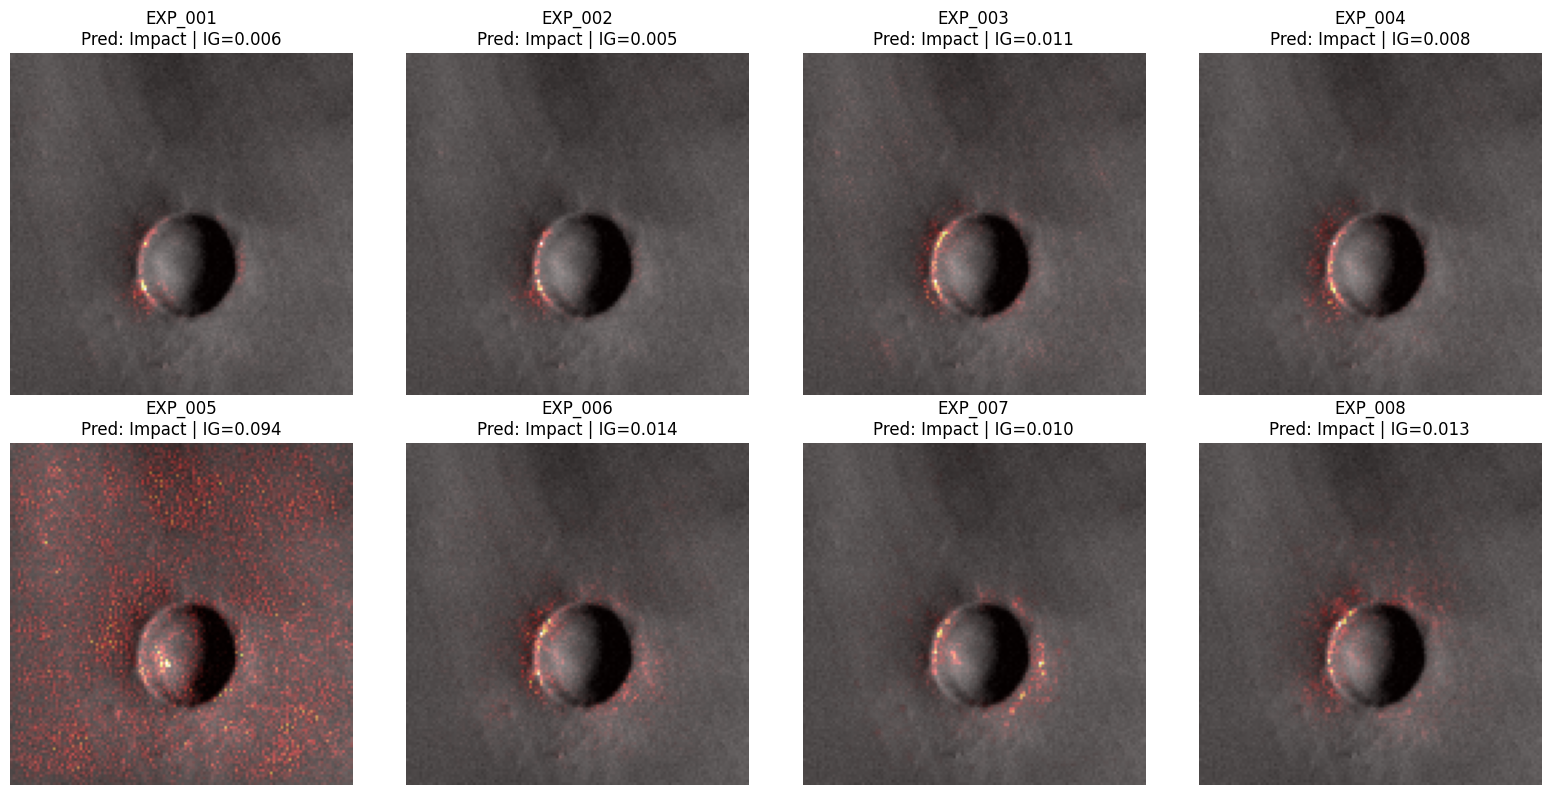

In [23]:
# IG Gradients
imgs, _ = test_gen[0]
img = imgs[0]
img_tf = tf.cast(img, tf.float32)

class_names = list(test_gen.class_indices.keys())
ig_results = {}

steps = 50
for name, model in zip(model_names, models):
    preds = model.predict(img[None, ...], verbose=0)
    if preds.shape[-1] == 1:
      # sigmoid output
        target_class = int(preds[0, 0] >= 0.5)
    else:
      # softmax output
        target_class = int(np.argmax(preds[0]))
    baseline = tf.zeros_like(img_tf)
    interpolated = []
    for i in range(steps + 1):
        alpha = i / steps
        interpolated.append(baseline + alpha * (img_tf - baseline))
    interpolated = tf.stack(interpolated)
    with tf.GradientTape() as tape:
        tape.watch(interpolated)
        preds_path = model(interpolated, training=False)
        loss = preds_path[:, target_class]

    grads = tape.gradient(loss, interpolated)
    # mean over path steps
    avg_grads = tf.reduce_mean(grads, axis=0)

    # elementwise multiply
    ig = (img_tf - baseline) * avg_grads
    ig = ig.numpy()

    # Reduce channel dimension properly
    if ig.ndim == 3:
        ig_map = np.abs(ig[:, :, 0])
    else:
        ig_map = np.abs(ig)

    ig_map_norm = (ig_map - ig_map.min()) / (ig_map.max() - ig_map.min() + 1e-8)
    ig_score = float(ig_map_norm.mean())

    ig_results[name] = {
        "class_idx": target_class,
        "class_name": class_names[target_class],
        "ig_map": ig_map_norm,
        "ig_score": ig_score
    }

    df.loc[df['experiment_id'] == name, 'ig_score'] = ig_score


# plot results
n = len(model_names)
cols = 4
rows = int(np.ceil(n / cols))

fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 4*rows))
axes = np.array(axes).reshape(-1)

for ax, name in zip(axes, model_names):
    res = ig_results[name]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.imshow(res["ig_map"], cmap='hot', alpha=0.45)
    ax.set_title(f"{name}\nPred: {res['class_name']} | IG={res['ig_score']:.3f}")
    ax.axis('off')
for ax in axes[n:]:
    ax.axis('off')

plt.tight_layout()
plt.show()


# CI

In [24]:
# Parametric Confidence intervals
y_true = test_gen.classes
test_steps = test_gen.samples // test_gen.batch_size + (test_gen.samples % test_gen.batch_size > 0)

results_list = []

print("Test Accuracy with Parametric 95% CI \n")
for name, model in zip(model_names, models):
    y_pred_prob = model.predict(test_gen, steps=test_steps, verbose=0)
    if name in categorical_models:
        y_pred = np.argmax(y_pred_prob, axis=1)
    else:
        y_pred = (y_pred_prob > 0.5).astype(int).flatten()

    acc = np.mean(y_true == y_pred)
    sem = st.sem(y_true == y_pred)

    ci_lower, ci_upper = st.t.interval(0.95, len(y_true)-1, loc=acc, scale=sem)

    results_list.append({
        "model": name,
        "accuracy": acc,
        "ci_lower": ci_lower,
        "ci_upper": ci_upper
    })

    df.loc[df['experiment_id'] == name, 'ci_lower'] = ci_lower
    df.loc[df['experiment_id'] == name, 'ci_upper'] = ci_upper

    print(f"{name} | Accuracy: {acc:.4f}, 95% CI: ({ci_lower:.4f}, {ci_upper:.4f})")




Test Accuracy with Parametric 95% CI 

EXP_001 | Accuracy: 0.8967, 95% CI: (0.8620, 0.9313)
EXP_002 | Accuracy: 0.9000, 95% CI: (0.8659, 0.9341)
EXP_003 | Accuracy: 0.8733, 95% CI: (0.8355, 0.9112)
EXP_004 | Accuracy: 0.9067, 95% CI: (0.8736, 0.9398)
EXP_005 | Accuracy: 0.5000, 95% CI: (0.4431, 0.5569)
EXP_006 | Accuracy: 0.9500, 95% CI: (0.9252, 0.9748)
EXP_007 | Accuracy: 0.9667, 95% CI: (0.9462, 0.9871)
EXP_008 | Accuracy: 0.9900, 95% CI: (0.9787, 1.0013)


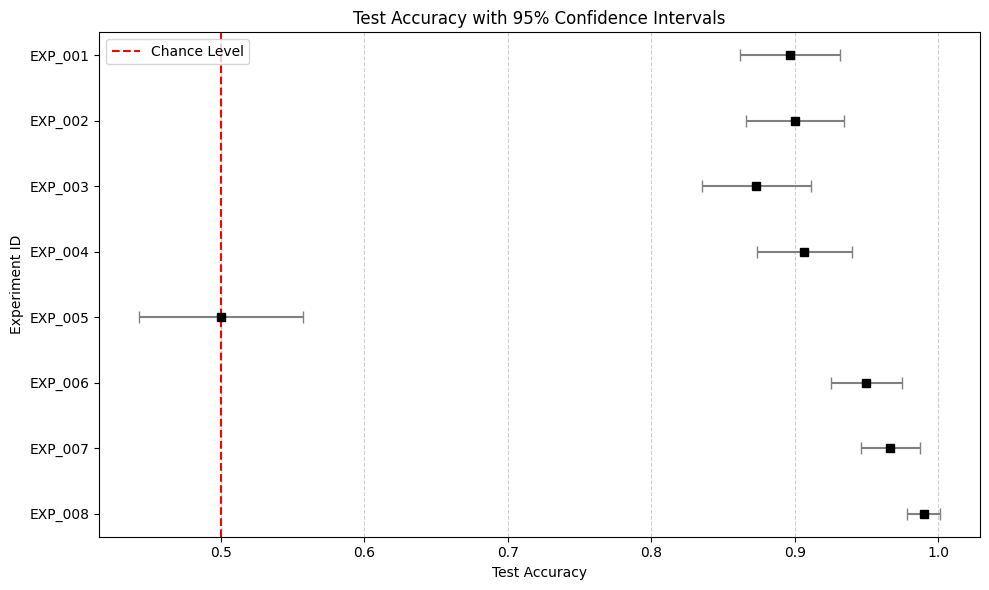

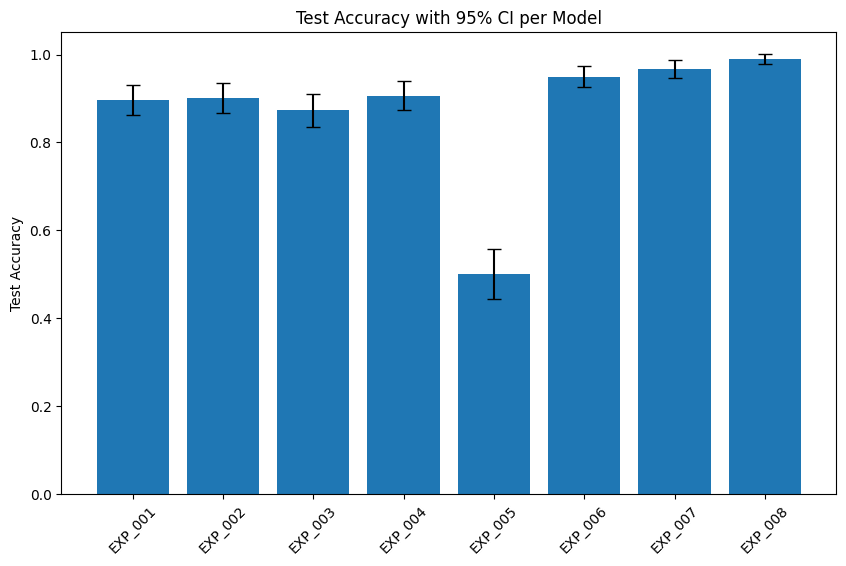

In [25]:
# Parametric Confidence intervals
# Test Accuracy with 95% CI

plt.figure(figsize=(10,6))
plt.errorbar(
    df["test_accuracy"],
    df["experiment_id"],
    xerr=[df["test_accuracy"] - df["ci_lower"], df["ci_upper"] - df["test_accuracy"]],
    fmt='s',
    color='black',
    ecolor='gray',
    elinewidth=1.5,
    capsize=4
)
plt.axvline(0.5, color='red', linestyle='--', label='Chance Level')
plt.xlabel("Test Accuracy")
plt.ylabel("Experiment ID")
plt.title("Test Accuracy with 95% Confidence Intervals")
plt.gca().invert_yaxis()
plt.legend(loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# Bar version

plt.figure(figsize=(10,6))
plt.bar(df['experiment_id'], df['test_accuracy'], yerr=[df['test_accuracy']-df['ci_lower'], df['ci_upper']-df['test_accuracy']], capsize=5)
plt.ylabel("Test Accuracy")
plt.xticks(rotation=45)
plt.title("Test Accuracy with 95% CI per Model")
plt.show()


# Cochran’s Q test and McNemar test

Cochran’s Q = 543.818, df=7, p = 0
Effect size proxy = 0.2590 (standardised Q)

Pairwise McNemar tests with Δ and OR (Holm corrected):


Model_A  Model_B    b    c         Δ  Δ_CI_low  Δ_CI_high         OR  \
24  EXP_005  EXP_008  149    2 -0.490000 -0.501715  -0.455995   0.496644   
23  EXP_005  EXP_007  147    7 -0.466667 -0.494373  -0.419486   0.416910   
22  EXP_005  EXP_006  147   12 -0.450000 -0.488020  -0.394190   0.234694   
18  EXP_004  EXP_005   16  138  0.406667  0.345746   0.451156   0.728261   
9   EXP_002  EXP_005   17  137  0.400000  0.337923   0.445947   0.742379   
3   EXP_001  EXP_005   20  139  0.396667  0.331183   0.446732   0.514388   
14  EXP_003  EXP_005   22  134  0.373333  0.306077   0.425840   0.694708   
17  EXP_003  EXP_008   37    2 -0.116667 -0.128369  -0.084956   3.513514   
6   EXP_001  EXP_008   29    1 -0.093333 -0.099831  -0.065566  18.482759   
16  EXP_003  EXP_007   30    2 -0.093333 -0.105032  -0.062279  34.666667   
12  EXP_002  EXP_008   29    2 -0.090000 -0.101698  -0.059062   4.620690   
21  EXP_004  EXP_008   27    2 -0.083333 -0.095030  -0.052652   5.000000   

    OR_CI_low  OR_CI_high         p_raw        p_holm  significant  
24   0.044552    5.536304  1.480265e-32  4.144741e-31         True  
23   0.105733    1.643897  4.034335e-29  1.089271e-27         True  
22   0.064844    0.849447  2.234366e-26  5.809352e-25         True  
18   0.332070    1.597145  1.836381e-22  4.590953e-21         True  
9    0.347006    1.588234  8.869042e-22  2.128570e-20         True  
3    0.237309    1.114984  8.125355e-21  1.868832e-19         True  
14   0.349137    1.382321  6.271748e-19  1.379785e-17         True  
17   0.310859   39.711856  5.199279e-08  1.091848e-06         True  
6    1.625796  210.120033  8.243906e-07  1.648781e-05         True  
16   7.034801  170.833222  1.815281e-06  3.449035e-05         True  
12   0.406449   52.530008  3.015843e-06  5.428518e-05         True  
21   0.438937   56.955721  8.323556e-06  1.415005e-04         True

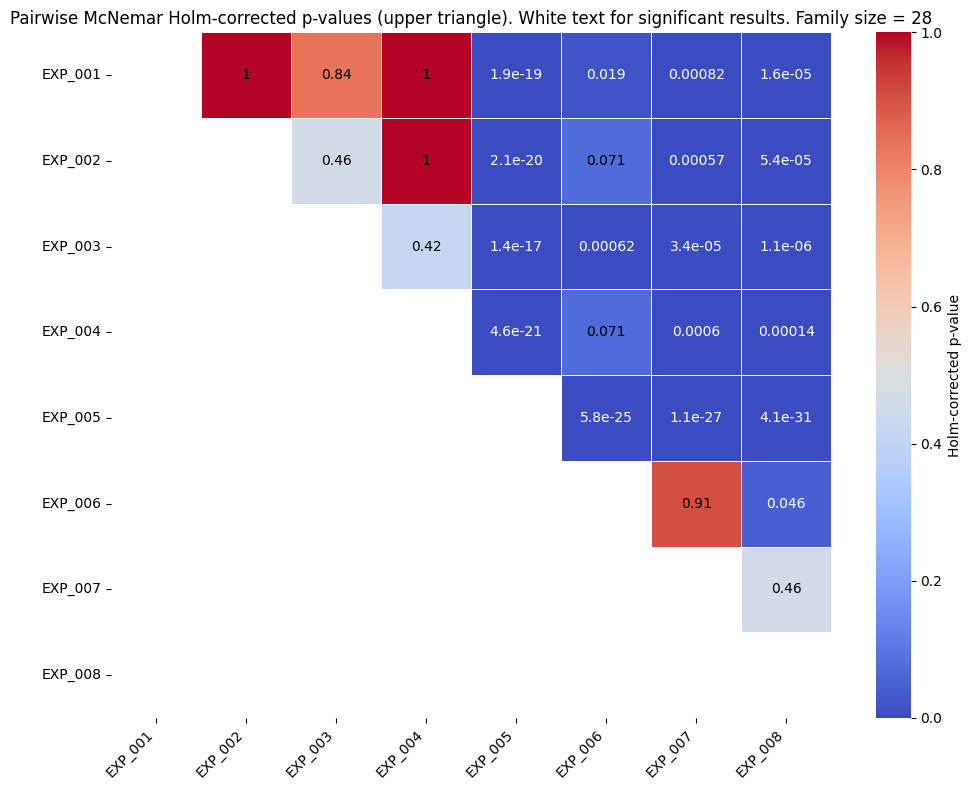

In [26]:
# Build prediction matrix (1 = correct)
y_true = results[model_names[0]]['y_true']
pred_matrix = np.column_stack([(results[m]['y_pred'] == y_true).astype(int) for m in model_names])
N, k = pred_matrix.shape

# Cochran’s Q test
col_sums = pred_matrix.sum(axis=0)
row_sums = pred_matrix.sum(axis=1)
T = col_sums.sum()

num = (k - 1) * (k * np.sum(col_sums**2) - T**2)
den = k * np.sum(row_sums) - np.sum(row_sums**2)
Q = num / den
p_q = 1 - chi2.cdf(Q, k - 1)
eff_size = Q / (N * (k - 1))

print(f"Cochran’s Q = {Q:.3f}, df={k-1}, p = {p_q:.3g}")
print(f"Effect size proxy = {eff_size:.4f} (standardised Q)")

#  Pairwise McNemar tests
rows = []
pvals = []

for i in range(k):
    for j in range(i+1, k):
        A, B = model_names[i], model_names[j]
        pa, pb = pred_matrix[:, i], pred_matrix[:, j]

        # discordant
        b = int(((pa == 0) & (pb == 1)).sum())
        c = int(((pa == 1) & (pb == 0)).sum())
        n_disc = b + c

        # McNemar contingency
        n00 = int(((pa == 0) & (pb == 0)).sum())
        n11 = int(((pa == 1) & (pb == 1)).sum())
        table = [[n00, b], [c, n11]]

        # test
        res = mcnemar(table, exact=True if n_disc < 25 else False)
        p = res.pvalue

        # delta and CI
        if n_disc > 0:
            delta = (c - b) / N
            p_hat = c / n_disc
            ci_low, ci_high = proportion_confint(c, n_disc, method='beta')
            delta_ci_low = (2 * ci_low - 1) * (n_disc / N)
            delta_ci_high = (2 * ci_high - 1) * (n_disc / N)
        else:
            delta, delta_ci_low, delta_ci_high = 0, 0, 0

        # odds ratio
        t2 = Table2x2(np.array(table))
        or_est = t2.oddsratio
        or_low, or_high = t2.oddsratio_confint()

        rows.append([A, B, b, c, delta, delta_ci_low, delta_ci_high, or_est, or_low, or_high, p])
        pvals.append(p)


# Multiple testing correction (Holm)
rej, p_corr, _, _ = multipletests(pvals, method='holm', alpha=0.05)

mcnemar_df = pd.DataFrame(rows, columns=[
    'Model_A','Model_B','b','c','Δ','Δ_CI_low','Δ_CI_high',
    'OR','OR_CI_low','OR_CI_high','p_raw'
])
mcnemar_df['p_holm'] = p_corr
mcnemar_df['significant'] = rej

print("\nPairwise McNemar tests with Δ and OR (Holm corrected):")
display(mcnemar_df.sort_values('p_holm').head(12))

# Define pairs properly (two elements)
pairs = [(row[0], row[1]) for row in rows]

# Heatmap
p_mat = np.full((k, k), np.nan)
for idx, (A, B) in enumerate(pairs):
    i = model_names.index(A)
    j = model_names.index(B)
    p_mat[i, j] = p_corr[idx]


plt.figure(figsize=(10, 8))
mask = np.tril(np.ones_like(p_mat, dtype=bool))
sns.heatmap(p_mat, mask=mask, annot=False, cmap='coolwarm',
            xticklabels=model_names, yticklabels=model_names,
            cbar_kws={'label': 'Holm-corrected p-value'}, vmin=0, vmax=1, linewidths=0.5)
# add p-value text manually for clarity
for i in range(k):
    for j in range(k):
        val = p_mat[i, j]
        if not np.isnan(val) and j > i:
            color = 'white' if val < 0.05 else 'black'
            plt.text(j + 0.5, i + 0.5, f"{val:.2g}", ha='center', va='center', color=color)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.title(f"Pairwise McNemar Holm-corrected p-values (upper triangle). White text for significant results. Family size = {int(k*(k-1)/2)}")
plt.tight_layout()
plt.show()

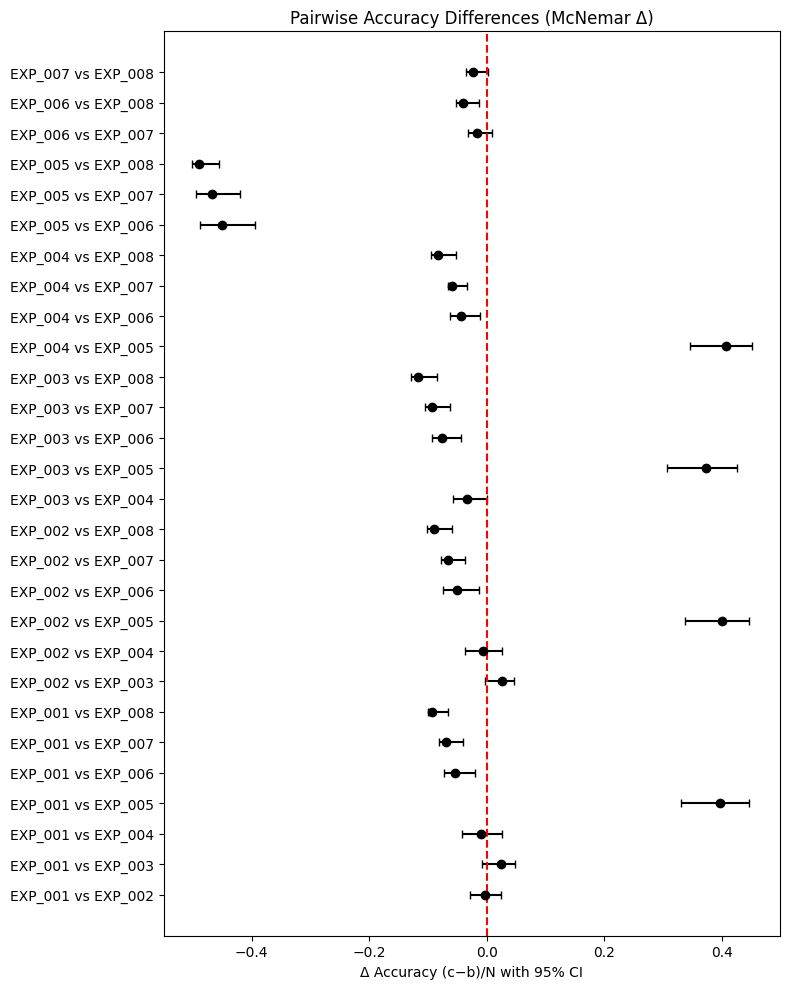

In [27]:
mcnemar_df['Comparison'] = mcnemar_df['Model_A'] + " vs " + mcnemar_df['Model_B']

# Forest plot for Δ (McNemar)
plt.figure(figsize=(8, 10))
y_pos = np.arange(len(mcnemar_df))

plt.errorbar(
    mcnemar_df['Δ'], y_pos,
    xerr=[mcnemar_df['Δ'] - mcnemar_df['Δ_CI_low'],
          mcnemar_df['Δ_CI_high'] - mcnemar_df['Δ']],
    fmt='o', color='black', capsize=3
)

plt.axvline(0, color='red', linestyle='--')
plt.yticks(y_pos, mcnemar_df['Comparison'])
plt.xlabel("Δ Accuracy (c−b)/N with 95% CI")
plt.title("Pairwise Accuracy Differences (McNemar Δ)")
plt.tight_layout()
plt.show()


# DeLong-style test

Model AUCs with 95% bootstrap CI:


model       AUC    CI_low   CI_high
0  EXP_001  0.952933  0.926695  0.974422
1  EXP_002  0.952933  0.929125  0.973957
2  EXP_003  0.941156  0.913006  0.965206
3  EXP_004  0.970667  0.954415  0.984823
4  EXP_005  0.580933  0.514379  0.646200
5  EXP_006  0.992133  0.984767  0.997445
6  EXP_007  0.994267  0.987330  0.998973
7  EXP_008  0.999689  0.998844  1.000000


Pairwise DeLong tests (Holm-corrected):


model_A  model_B          ΔAUC          z         p_raw        p_holm  \
24  EXP_005  EXP_008 -4.187556e-01  12.657284  1.019664e-36  2.855058e-35   
22  EXP_005  EXP_006 -4.112000e-01  12.412755  2.228518e-35  6.016998e-34   
23  EXP_005  EXP_007 -4.133333e-01  12.354162  4.625520e-35  1.202635e-33   
18  EXP_004  EXP_005  3.897333e-01 -11.648091  2.346571e-31  5.866428e-30   
9   EXP_002  EXP_005  3.720000e-01 -11.083498  1.508614e-28  3.620674e-27   
3   EXP_001  EXP_005  3.720000e-01 -10.896762  1.194318e-27  2.746931e-26   
14  EXP_003  EXP_005  3.602222e-01 -10.466130  1.235932e-25  2.719051e-24   
15  EXP_003  EXP_006 -5.097778e-02   4.415709  1.006794e-05  2.114267e-04   
17  EXP_003  EXP_008 -5.853333e-02   4.308516  1.643533e-05  3.287066e-04   
16  EXP_003  EXP_007 -5.311111e-02   4.229303  2.344167e-05  4.453917e-04   
12  EXP_002  EXP_008 -4.675556e-02   3.999823  6.338982e-05  1.141017e-03   
11  EXP_002  EXP_007 -4.133333e-02   3.928790  8.537423e-05  1.451362e-03   
10  EXP_002  EXP_006 -3.920000e-02   3.784544  1.539904e-04  2.463847e-03   
6   EXP_001  EXP_008 -4.675556e-02   3.735937  1.870177e-04  2.805266e-03   
4   EXP_001  EXP_006 -3.920000e-02   3.661596  2.506493e-04  3.463493e-03   
21  EXP_004  EXP_008 -2.902222e-02   3.664944  2.473923e-04  3.463493e-03   
5   EXP_001  EXP_007 -4.133333e-02   3.598893  3.195749e-04  3.834899e-03   
19  EXP_004  EXP_006 -2.146667e-02   3.443097  5.750932e-04  6.326025e-03   
13  EXP_003  EXP_004 -2.951111e-02   3.330408  8.671895e-04  8.671895e-03   
20  EXP_004  EXP_007 -2.360000e-02   3.250493  1.152050e-03  1.036845e-02   
26  EXP_006  EXP_008 -7.555556e-03   2.361288  1.821156e-02  1.456925e-01   
8   EXP_002  EXP_004 -1.773333e-02   2.208130  2.723519e-02  1.906463e-01   
2   EXP_001  EXP_004 -1.773333e-02   2.106413  3.516850e-02  2.110110e-01   
27  EXP_007  EXP_008 -5.422222e-03   1.866564  6.196252e-02  3.098126e-01   
1   EXP_001  EXP_003  1.177778e-02  -1.691113  9.081521e-02  3.632609e-01   
7   EXP_002  EXP_003  1.177778e-02  -1.606234  1.082225e-01  3.632609e-01   
0   EXP_001  EXP_002  1.110223e-16   0.000000  1.000000e+00  1.000000e+00   
25  EXP_006  EXP_007 -2.133333e-03   0.632252  5.272221e-01  1.000000e+00   

    reject_holm  
24         True  
22         True  
23         True  
18         True  
9          True  
3          True  
14         True  
15         True  
17         True  
16         True  
12         True  
11         True  
10         True  
6          True  
4          True  
21         True  
5          True  
19         True  
13         True  
20         True  
26        False  
8         False  
2         False  
27        False  
1         False  
7         False  
0         False  
25        False

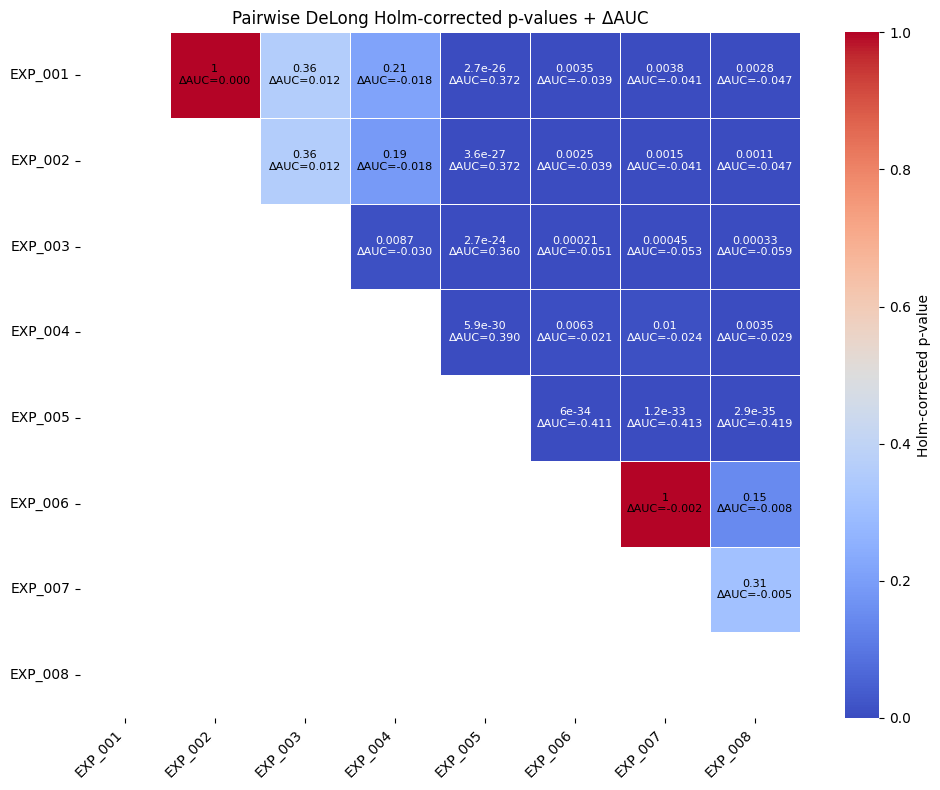

In [28]:

# Bootstrap 95% CIs for model AUCs
rng = np.random.default_rng(42)
n_boot = 2000
auc_rows = []

for model in model_names:
    y_true = results[model]['y_true']
    y_score = results[model]['y_score']

    auc = roc_auc_score(y_true, y_score)

    # Bootstrap AUC distribution
    n = len(y_true)
    idx_matrix = rng.integers(0, n, size=(n_boot, n))
    boot_aucs = [roc_auc_score(y_true[idx], y_score[idx]) for idx in idx_matrix]

    ci_low, ci_high = np.percentile(boot_aucs, [2.5, 97.5])

    auc_rows.append({
        "model": model,
        "AUC": auc,
        "CI_low": ci_low,
        "CI_high": ci_high
    })

auc_df = pd.DataFrame(auc_rows)
print("Model AUCs with 95% bootstrap CI:")
display(auc_df)


# Pairwise DeLong tests
delong_rows = []

for m1, m2 in combinations(model_names, 2):
    y_true = results[m1]['y_true']
    # same truth for all models
    score1 = results[m1]['y_score']
    score2 = results[m2]['y_score']

    out = Delong_test(y_true, score1, score2)
    z, p = out[0], out[1]
    # first two entries always z, p

    auc1 = auc_df.loc[auc_df.model == m1, "AUC"].iloc[0]
    auc2 = auc_df.loc[auc_df.model == m2, "AUC"].iloc[0]

    delong_rows.append({
        "model_A": m1,
        "model_B": m2,
        "ΔAUC": auc1 - auc2,
        "z": float(z),
        "p_raw": float(p)
    })

delong_df = pd.DataFrame(delong_rows)


# Holm correction
reject, p_holm, _, _ = multipletests(delong_df["p_raw"], method="holm", alpha=0.05)

delong_df["p_holm"] = p_holm
delong_df["reject_holm"] = reject

print("\nPairwise DeLong tests (Holm-corrected):")
display(delong_df.sort_values("p_holm"))


# Heatmap of Holm-corrected p-values
n = len(model_names)
p_mat = np.full((n, n), np.nan)

# Fill upper triangle
for _, row in delong_df.iterrows():
    i = model_names.index(row["model_A"])
    j = model_names.index(row["model_B"])
    p_mat[i, j] = row["p_holm"]

plt.figure(figsize=(10, 8))
mask = np.tril(np.ones((n, n), dtype=bool))

ax = sns.heatmap(
    p_mat, mask=mask, annot=False, cmap="coolwarm", vmin=0, vmax=1,
    xticklabels=model_names, yticklabels=model_names,
    cbar_kws={'label': 'Holm-corrected p-value'},
    linewidths=0.5
)

# Add ΔAUC + p-value text labels
for _, row in delong_df.iterrows():
    i = model_names.index(row["model_A"])
    j = model_names.index(row["model_B"])
    if j > i:
        val = row["p_holm"]
        label = f"{val:.2g}\nΔAUC={row['ΔAUC']:.3f}"
        color = "white" if val < 0.05 else "black"
        plt.text(j + 0.5, i + 0.5, label,
                 ha="center", va="center", color=color, fontsize=8)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.title("Pairwise DeLong Holm-corrected p-values + ΔAUC")
plt.tight_layout()
plt.show()


# AUC difference

In [29]:
# ΔAUC


bootstrap_results = []
n_boot = 2000
seed = 123
rng = np.random.RandomState(seed)

for a, b in combinations(model_names, 2):
    y = np.array(results[a]['y_true'])
    score_a = np.array(results[a]['y_score'])
    score_b = np.array(results[b]['y_score'])

    diffs = []
    n = len(y)
    for _ in range(n_boot):
        idx = rng.randint(0, n, n)
        try:
            a_auc = roc_auc_score(y[idx], score_a[idx])
            b_auc = roc_auc_score(y[idx], score_b[idx])
            diffs.append(a_auc - b_auc)
        except:
            continue
    diffs = np.array(diffs)

    mean_diff = diffs.mean()
    ci_low, ci_high = np.percentile(diffs, [2.5, 97.5])
    p_two_sided = 2 * min((diffs <= 0).mean(), (diffs >= 0).mean())

    bootstrap_results.append({
        'model_A': a,
        'model_B': b,
        'mean_diff': mean_diff,
        'ci_low': ci_low,
        'ci_high': ci_high,
        'p': p_two_sided
    })

    print(f"Bootstrap AUC diff {a} - {b}: mean={mean_diff:.4f}, 95% CI=({ci_low:.4f},{ci_high:.4f}), p~{p_two_sided:.4f}")

boot_df = pd.DataFrame(bootstrap_results)
boot_df


Bootstrap AUC diff EXP_001 - EXP_002: mean=-0.0002, 95% CI=(-0.0136,0.0126), p~0.9970
Bootstrap AUC diff EXP_001 - EXP_003: mean=0.0117, 95% CI=(-0.0025,0.0249), p~0.1010
Bootstrap AUC diff EXP_001 - EXP_004: mean=-0.0177, 95% CI=(-0.0353,-0.0023), p~0.0200
Bootstrap AUC diff EXP_001 - EXP_005: mean=0.3711, 95% CI=(0.3053,0.4391), p~0.0000
Bootstrap AUC diff EXP_001 - EXP_006: mean=-0.0391, 95% CI=(-0.0614,-0.0201), p~0.0000
Bootstrap AUC diff EXP_001 - EXP_007: mean=-0.0413, 95% CI=(-0.0653,-0.0206), p~0.0000
Bootstrap AUC diff EXP_001 - EXP_008: mean=-0.0465, 95% CI=(-0.0741,-0.0229), p~0.0000
Bootstrap AUC diff EXP_002 - EXP_003: mean=0.0117, 95% CI=(-0.0027,0.0262), p~0.1200
Bootstrap AUC diff EXP_002 - EXP_004: mean=-0.0180, 95% CI=(-0.0346,-0.0034), p~0.0230
Bootstrap AUC diff EXP_002 - EXP_005: mean=0.3724, 95% CI=(0.3054,0.4413), p~0.0000
Bootstrap AUC diff EXP_002 - EXP_006: mean=-0.0392, 95% CI=(-0.0614,-0.0205), p~0.0000
Bootstrap AUC diff EXP_002 - EXP_007: mean=-0.0415, 95

model_A  model_B  mean_diff    ci_low   ci_high      p
0   EXP_001  EXP_002  -0.000249 -0.013639  0.012562  0.997
1   EXP_001  EXP_003   0.011681 -0.002495  0.024866  0.101
2   EXP_001  EXP_004  -0.017724 -0.035263 -0.002324  0.020
3   EXP_001  EXP_005   0.371110  0.305261  0.439074  0.000
4   EXP_001  EXP_006  -0.039105 -0.061383 -0.020119  0.000
5   EXP_001  EXP_007  -0.041256 -0.065271 -0.020564  0.000
6   EXP_001  EXP_008  -0.046545 -0.074071 -0.022936  0.000
7   EXP_002  EXP_003   0.011722 -0.002652  0.026230  0.120
8   EXP_002  EXP_004  -0.018034 -0.034595 -0.003421  0.023
9   EXP_002  EXP_005   0.372406  0.305374  0.441320  0.000
10  EXP_002  EXP_006  -0.039184 -0.061402 -0.020467  0.000
11  EXP_002  EXP_007  -0.041465 -0.064858 -0.022841  0.000
12  EXP_002  EXP_008  -0.046365 -0.070450 -0.025490  0.000
13  EXP_003  EXP_004  -0.029614 -0.048324 -0.013425  0.000
14  EXP_003  EXP_005   0.360578  0.295359  0.423502  0.000
15  EXP_003  EXP_006  -0.051024 -0.074765 -0.031562  0.000
16  EXP_003  EXP_007  -0.053228 -0.080509 -0.030982  0.000
17  EXP_003  EXP_008  -0.058053 -0.086662 -0.034074  0.000
18  EXP_004  EXP_005   0.390483  0.324990  0.455324  0.000
19  EXP_004  EXP_006  -0.021598 -0.035198 -0.010188  0.000
20  EXP_004  EXP_007  -0.023652 -0.040137 -0.010715  0.000
21  EXP_004  EXP_008  -0.028972 -0.046324 -0.015579  0.000
22  EXP_005  EXP_006  -0.409990 -0.474283 -0.346348  0.000
23  EXP_005  EXP_007  -0.413115 -0.477103 -0.349876  0.000
24  EXP_005  EXP_008  -0.419331 -0.483376 -0.357554  0.000
25  EXP_006  EXP_007  -0.002182 -0.009021  0.004673  0.504
26  EXP_006  EXP_008  -0.007519 -0.014669 -0.002226  0.001
27  EXP_007  EXP_008  -0.005513 -0.012153 -0.000719  0.008

In [30]:
# Bootstrap CIs for AUC and AP per model
def bootstrap_metric_ci(y_true, score, metric_fn, n_boot=2000, seed=42):
    rng = np.random.RandomState(seed)
    n = len(y_true)
    vals = np.zeros(n_boot)
    for i in range(n_boot):
        idx = rng.randint(0, n, n)
        try:
            vals[i] = metric_fn(y_true[idx], score[idx])
        except:
            vals[i] = np.nan
    vals = vals[~np.isnan(vals)]
    mean = vals.mean()
    lo, hi = np.percentile(vals, [2.5, 97.5])
    return mean, lo, hi

ci_rows = []
for m in model_names:
    y = results[m]['y_true']
    s = results[m]['y_score']
    mean_auc, lo_auc, hi_auc = bootstrap_metric_ci(y, s, roc_auc_score, n_boot=2000, seed=1)
    mean_ap, lo_ap, hi_ap = bootstrap_metric_ci(y, s, average_precision_score, n_boot=2000, seed=2)
    ci_rows.append({'model':m, 'auc_mean':mean_auc, 'auc_lo':lo_auc, 'auc_hi':hi_auc,
                              'ap_mean':mean_ap, 'ap_lo':lo_ap, 'ap_hi':hi_ap})
ci_df = pd.DataFrame(ci_rows)
print(ci_df)


     model  auc_mean    auc_lo    auc_hi   ap_mean     ap_lo     ap_hi
0  EXP_001  0.952858  0.927251  0.976312  0.931460  0.879657  0.973484
1  EXP_002  0.952767  0.927885  0.975065  0.944143  0.905970  0.973454
2  EXP_003  0.940890  0.913159  0.965691  0.919685  0.861154  0.963234
3  EXP_004  0.970650  0.953587  0.984940  0.970806  0.950603  0.985623
4  EXP_005  0.581967  0.515890  0.647277  0.547994  0.464530  0.627997
5  EXP_006  0.992120  0.984717  0.997275  0.991760  0.983308  0.997518
6  EXP_007  0.994184  0.987243  0.998888  0.994617  0.988428  0.998980
7  EXP_008  0.999690  0.998755  1.000000  0.999712  0.998897  1.000000


In [31]:
# Per-model AUC with bootstrap CI
n_boot = 2000
rng = np.random.default_rng(42)
auc_rows = []

for m in model_names:
    y = np.array(results[m]['y_true'])
    s = np.array(results[m]['y_score'])

    boot_aucs = []
    for _ in range(n_boot):
        idx = rng.choice(len(y), len(y), replace=True)
        boot_aucs.append(roc_auc_score(y[idx], s[idx]))
    ci_low, ci_high = np.percentile(boot_aucs, [2.5, 97.5])
    auc = roc_auc_score(y, s)

    auc_rows.append({'model': m, 'AUC': auc, 'CI_low': ci_low, 'CI_high': ci_high})

auc_df = pd.DataFrame(auc_rows)
print("Per-model AUCs with 95% bootstrap CI:")
display(auc_df)


# Pairwise bootstrap ΔAUC
diff_rows, pvals = [], []
for a, b in combinations(model_names, 2):
    y = np.array(results[a]['y_true'])
    sa, sb = np.array(results[a]['y_score']), np.array(results[b]['y_score'])

    diffs = []
    for _ in range(n_boot):
        idx = rng.choice(len(y), len(y), replace=True)
        diffs.append(roc_auc_score(y[idx], sa[idx]) - roc_auc_score(y[idx], sb[idx]))
    diffs = np.array(diffs)

    mean_diff = diffs.mean()
    ci_low, ci_high = np.percentile(diffs, [2.5, 97.5])
    p = 2 * min((diffs <= 0).mean(), (diffs >= 0).mean())  # 2-sided
    pvals.append(p)

    diff_rows.append({'model_A': a, 'model_B': b,
                      'ΔAUC': mean_diff, 'CI_low': ci_low, 'CI_high': ci_high,
                      'p_raw': p})

diff_df = pd.DataFrame(diff_rows)

# Holm correction
rej, p_corr, _, _ = multipletests(pvals, method='holm')
diff_df['p_holm'] = p_corr
diff_df['significant'] = rej

print("\nPairwise bootstrap ΔAUC (Holm corrected):")
display(diff_df.sort_values('p_holm').head(12))




Per-model AUCs with 95% bootstrap CI:


model       AUC    CI_low   CI_high
0  EXP_001  0.952933  0.926695  0.974422
1  EXP_002  0.952933  0.929125  0.973957
2  EXP_003  0.941156  0.913006  0.965206
3  EXP_004  0.970667  0.954415  0.984823
4  EXP_005  0.580933  0.514379  0.646200
5  EXP_006  0.992133  0.984767  0.997445
6  EXP_007  0.994267  0.987330  0.998973
7  EXP_008  0.999689  0.998844  1.000000


Pairwise bootstrap ΔAUC (Holm corrected):


model_A  model_B      ΔAUC    CI_low   CI_high  p_raw  p_holm  significant
3   EXP_001  EXP_005  0.372228  0.305145  0.436542    0.0     0.0         True
6   EXP_001  EXP_008 -0.046773 -0.075078 -0.024225    0.0     0.0         True
5   EXP_001  EXP_007 -0.041598 -0.065293 -0.021535    0.0     0.0         True
4   EXP_001  EXP_006 -0.038947 -0.061744 -0.020464    0.0     0.0         True
12  EXP_002  EXP_008 -0.046575 -0.070780 -0.025646    0.0     0.0         True
11  EXP_002  EXP_007 -0.041679 -0.063519 -0.022544    0.0     0.0         True
10  EXP_002  EXP_006 -0.038747 -0.060651 -0.020466    0.0     0.0         True
9   EXP_002  EXP_005  0.371377  0.306047  0.436765    0.0     0.0         True
14  EXP_003  EXP_005  0.360757  0.295470  0.427580    0.0     0.0         True
13  EXP_003  EXP_004 -0.029728 -0.049254 -0.013290    0.0     0.0         True
15  EXP_003  EXP_006 -0.051269 -0.075125 -0.030094    0.0     0.0         True
20  EXP_004  EXP_007 -0.023649 -0.038956 -0.010677    0.0     0.0         True

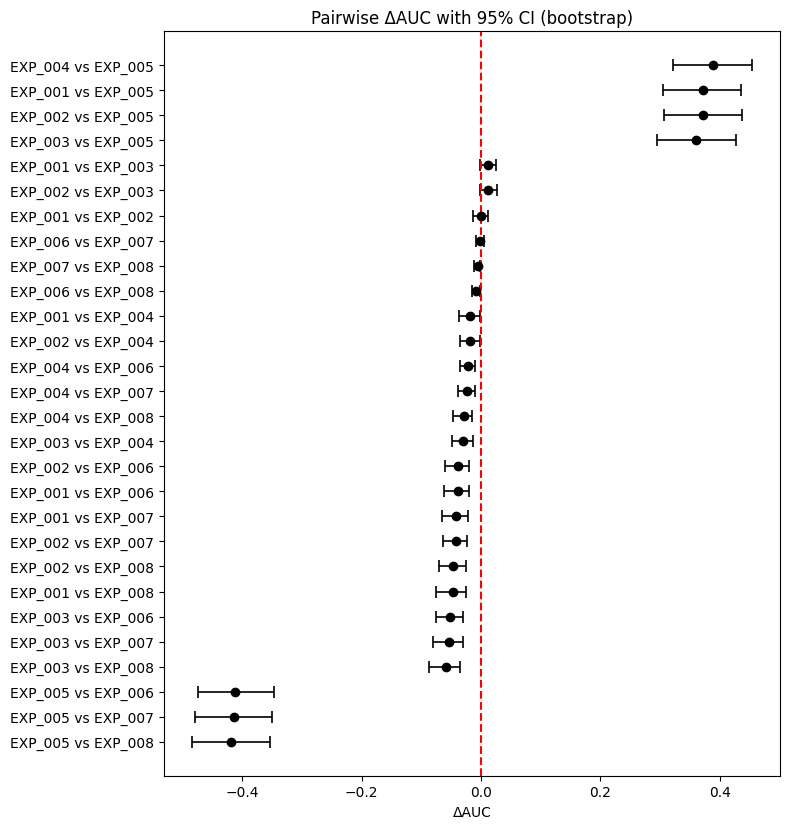

In [32]:


# Forest plot of ΔAUC
sorted_df = diff_df.sort_values('ΔAUC').reset_index(drop=True)

plt.figure(figsize=(8, len(sorted_df)*0.3))
for i, row in sorted_df.iterrows():
    plt.errorbar(
        x=row["ΔAUC"],
        y=i,
        xerr=[[row["ΔAUC"] - row["CI_low"]],
              [row["CI_high"] - row["ΔAUC"]]],
        fmt="o",
        color="black",
        ecolor="black",
        elinewidth=1.2,
        capsize=4,
        capthick=1.2
    )

plt.axvline(0, color="red", linestyle="--")
plt.yticks(range(len(sorted_df)), sorted_df["model_A"] + " vs " + sorted_df["model_B"])
plt.title("Pairwise ΔAUC with 95% CI (bootstrap)")
plt.xlabel("ΔAUC")
plt.tight_layout()
plt.show()



In [33]:
# Add LLM and Prompt columns
auc_df["LLM"] = auc_df["model"].map(lambda x: FACTOR_MAP[x][0])
auc_df["Prompt"] = auc_df["model"].map(lambda x: FACTOR_MAP[x][1])
auc_df

model       AUC    CI_low   CI_high      LLM   Prompt
0  EXP_001  0.952933  0.926695  0.974422  ChatGPT  Minimal
1  EXP_002  0.952933  0.929125  0.973957  ChatGPT      CoT
2  EXP_003  0.941156  0.913006  0.965206  ChatGPT     sCoT
3  EXP_004  0.970667  0.954415  0.984823  ChatGPT     Role
4  EXP_005  0.580933  0.514379  0.646200   Claude  Minimal
5  EXP_006  0.992133  0.984767  0.997445   Claude      CoT
6  EXP_007  0.994267  0.987330  0.998973   Claude     sCoT
7  EXP_008  0.999689  0.998844  1.000000   Claude     Role

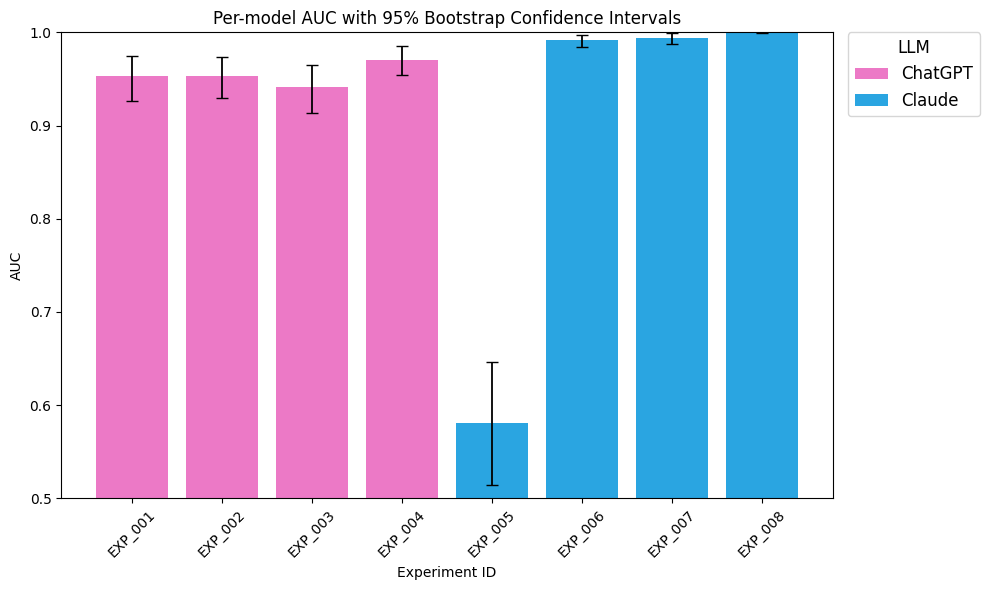

In [34]:
# Per-model AUC with 95% Bootstrap Confidence Intervals


auc_df["LLM"] = auc_df["model"].map(lambda x: FACTOR_MAP[x][0])
auc_df["Prompt"] = auc_df["model"].map(lambda x: FACTOR_MAP[x][1])

plt.figure(figsize=(10,6))

sns.barplot(
    data=auc_df,
    x="model",
    y="AUC",
    hue="LLM",
    palette=LLM_COLORS,
    dodge=False,
    errorbar=None
)

for i, row in auc_df.iterrows():
    plt.errorbar(
        x=i,
        y=row["AUC"],
        yerr=[[row["AUC"] - row["CI_low"]], [row["CI_high"] - row["AUC"]]],
        fmt="none",
        ecolor="black",
        elinewidth=1.3,
        capsize=4
    )

plt.ylim(0.5, 1.0)
plt.xlabel("Experiment ID")
plt.ylabel("AUC")
plt.title("Per-model AUC with 95% Bootstrap Confidence Intervals")
plt.xticks(rotation=45)
plt.legend(
    title="LLM",
    fontsize=12,
    title_fontsize=12,
    bbox_to_anchor=(1.02, 1),
    loc="upper left",
    borderaxespad=0
)

plt.tight_layout()
plt.show()


# Convergence speed

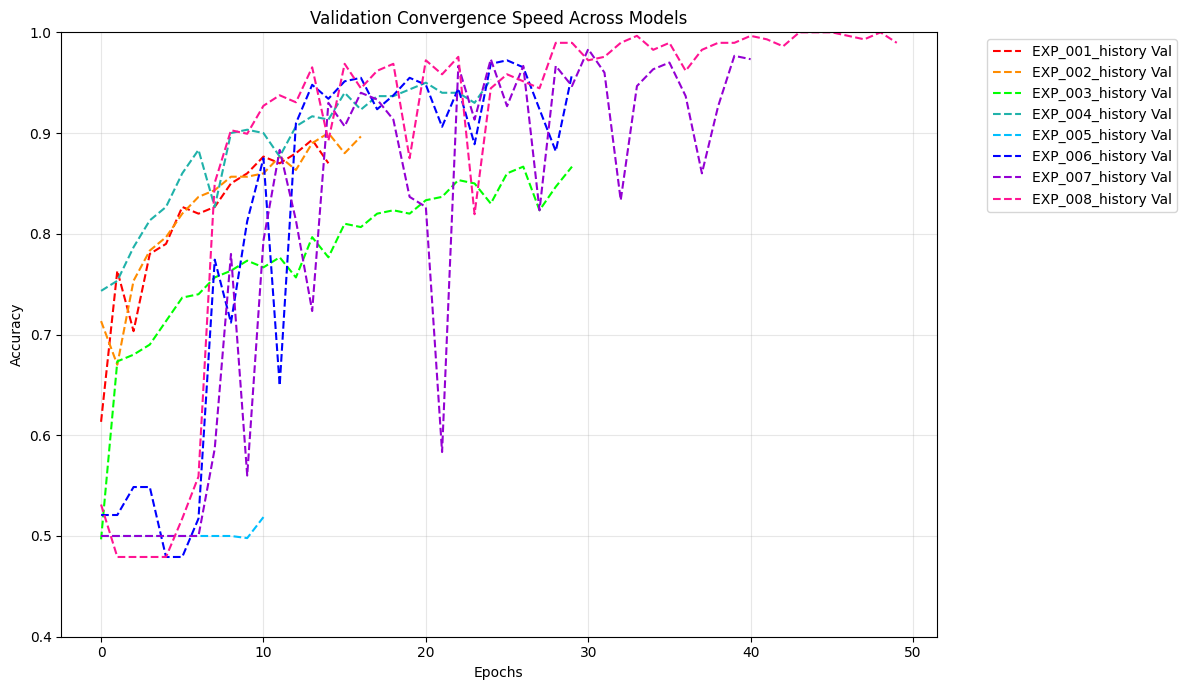

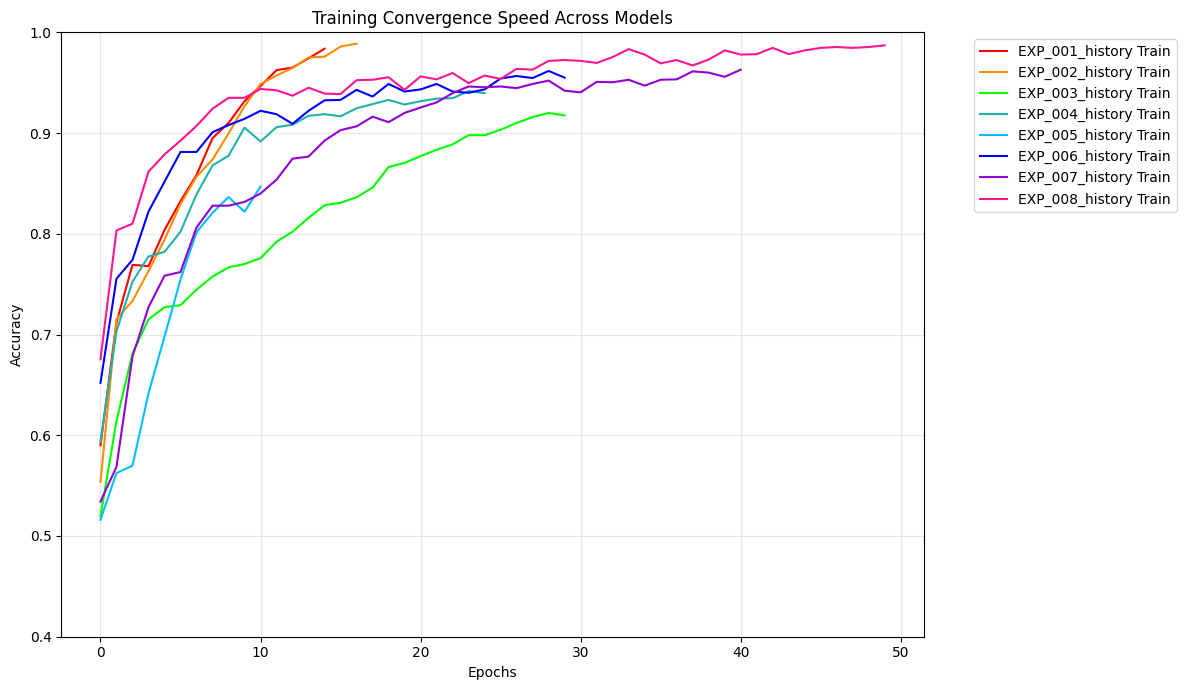

In [35]:
# VAL speed

colors = itertools.cycle([
    'red', 'darkorange', 'lime', 'lightseagreen',
    'deepskyblue', 'blue', 'darkviolet', 'deeppink'
])

def plot_convergence(histories, names):
    plt.figure(figsize=(12,7))
    for hist, name in zip(histories, names):
        color = next(colors)
        plt.plot(hist['val_accuracy'], linestyle="--", color=color, label=f"{name} Val")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Validation Convergence Speed Across Models")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.ylim(0.4, 1)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_convergence(history, history_names)

# TRAIN speed


def plot_convergence(histories, names):
    plt.figure(figsize=(12,7))
    for hist, name in zip(histories, names):
        color = next(colors)
        plt.plot(hist['accuracy'], label=f"{name} Train", color=color, linestyle='-')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training Convergence Speed Across Models")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.ylim(0.4, 1)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_convergence(history, history_names)




# Architecture Analysis

In [36]:

llm_name_map = {'openai': 'ChatGPT', 'anthropic': 'Claude'}
df['LLM_label'] = df['llm_company'].map(llm_name_map)

In [37]:
# pull data
ayers_list, params_list, epochs_list = [], [], []

for name, m, hist in zip(model_names, models, history):
    layers = len(m.layers)
    params = m.count_params()
    epochs = len(hist['accuracy'])

    layers_list.append(layers)
    params_list.append(params)
    epochs_list.append(epochs)

    df.loc[df['experiment_id'] == name, 'layers'] = layers
    df.loc[df['experiment_id'] == name, 'params'] = params
    df.loc[df['experiment_id'] == name, 'epochs'] = epochs



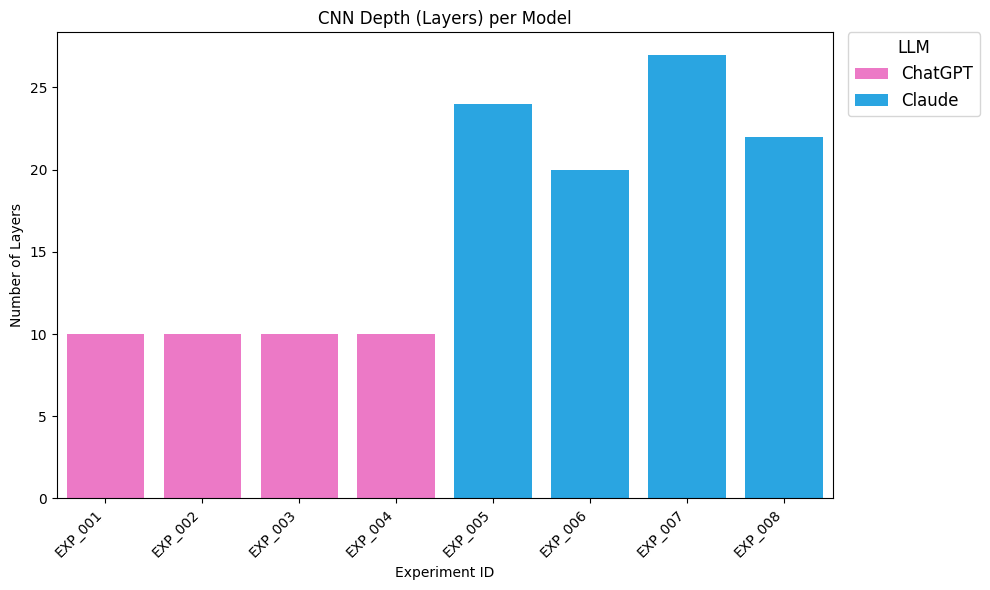

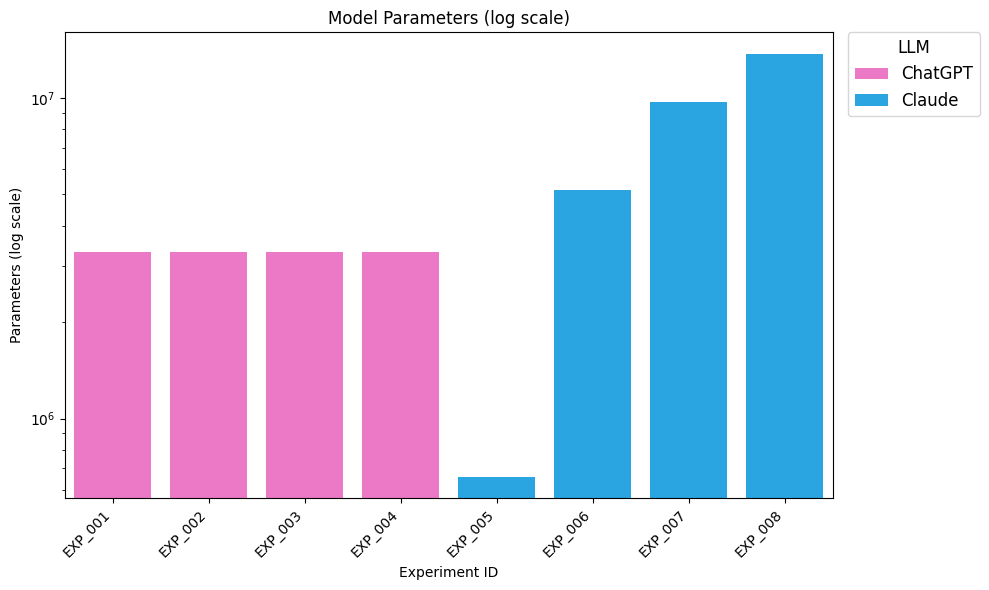

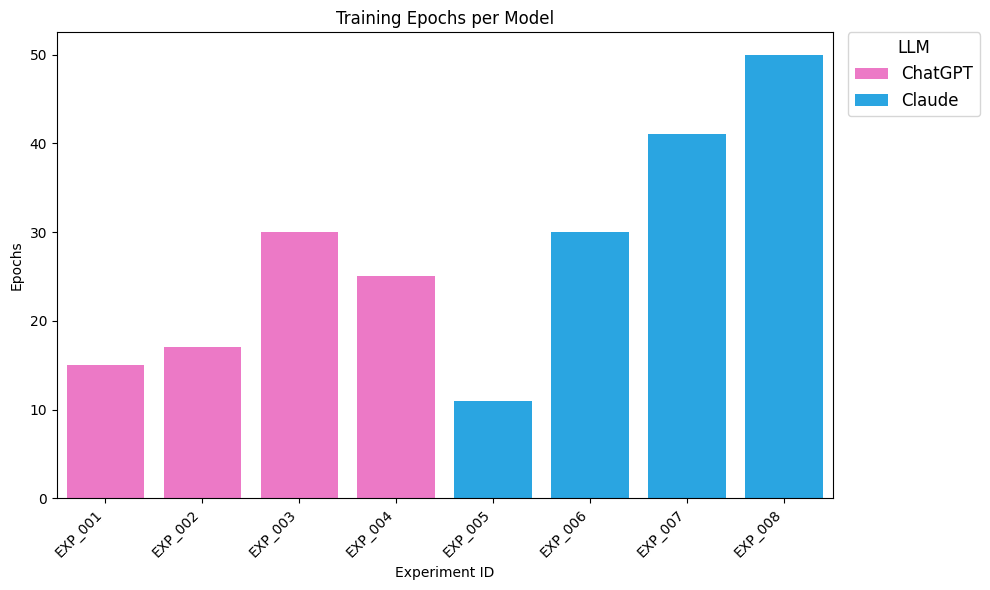

In [38]:
# Layers per model

plt.figure(figsize=(10,6))
sns.barplot(x="experiment_id", y="layers", hue='LLM', palette=LLM_COLORS, data=df)
plt.xticks(rotation=45, ha="right")
plt.title("CNN Depth (Layers) per Model")
plt.ylabel("Number of Layers")
plt.xlabel("Experiment ID")
plt.legend(title="LLM", fontsize=12, title_fontsize=12, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

# parameters per model

plt.figure(figsize=(10,6))
sns.barplot(x="experiment_id", y="params", hue='LLM', palette=LLM_COLORS, data=df)
plt.yscale("log")
plt.xticks(rotation=45, ha="right")
plt.title("Model Parameters (log scale)")
plt.ylabel("Parameters (log scale)")
plt.xlabel("Experiment ID")
plt.legend(title="LLM", fontsize=12, title_fontsize=12, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()

# epochs per model

plt.figure(figsize=(10,6))
sns.barplot(x="experiment_id", y="epochs", hue='LLM', palette=LLM_COLORS, data=df)
plt.xticks(rotation=45, ha="right")
plt.title("Training Epochs per Model")
plt.ylabel("Epochs")
plt.xlabel("Experiment ID")
plt.legend(title="LLM", fontsize=12, title_fontsize=12, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.tight_layout()
plt.show()


# Precision

In [39]:

# Update df for this model

df["y_true"] = df["y_true"].apply(lambda x: [int(i) for i in x])
df["y_pred"] = df["y_pred"].apply(lambda x: [int(i) for i in x])
df["precision_impact"] = df.apply(
    lambda row: precision_score(row["y_true"], row["y_pred"], pos_label=0, zero_division=0),
    axis=1
)


def bootstrap_precision(y_true, y_pred, n_boot=1000, pos_label=1):
    scores = []
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    for _ in range(n_boot):
        idx = np.random.randint(0, len(y_true), len(y_true))
        yt_bs, yp_bs = y_true[idx], y_pred[idx]
        score = precision_score(yt_bs, yp_bs, pos_label=pos_label, zero_division=0)
        scores.append(score)
    return np.percentile(scores, [2.5, 50, 97.5])  # lower, median, upper

# Apply to df
df[["prec_lower", "prec_median", "prec_upper"]] = df.apply(
    lambda row: pd.Series(bootstrap_precision(row["y_true"], row["y_pred"], pos_label=0)),
    axis=1
)


In [40]:
df[["experiment_id", "precision_impact", "prec_lower", "prec_upper"]]


experiment_id  precision_impact  prec_lower  prec_upper
0       EXP_001          0.921986    0.874978    0.962976
1       EXP_002          0.910959    0.861835    0.953642
2       EXP_003          0.888889    0.833333    0.936761
3       EXP_004          0.917808    0.871617    0.959184
4       EXP_005          0.500000    0.436667    0.553333
5       EXP_006          0.978723    0.953122    1.000000
6       EXP_007          0.979452    0.954190    1.000000
7       EXP_008          0.993289    0.979167    1.000000

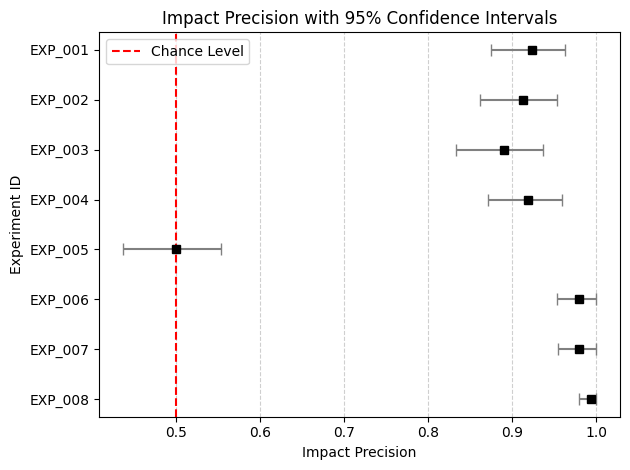

/tmp/ipython-input-3126001216.py:26: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


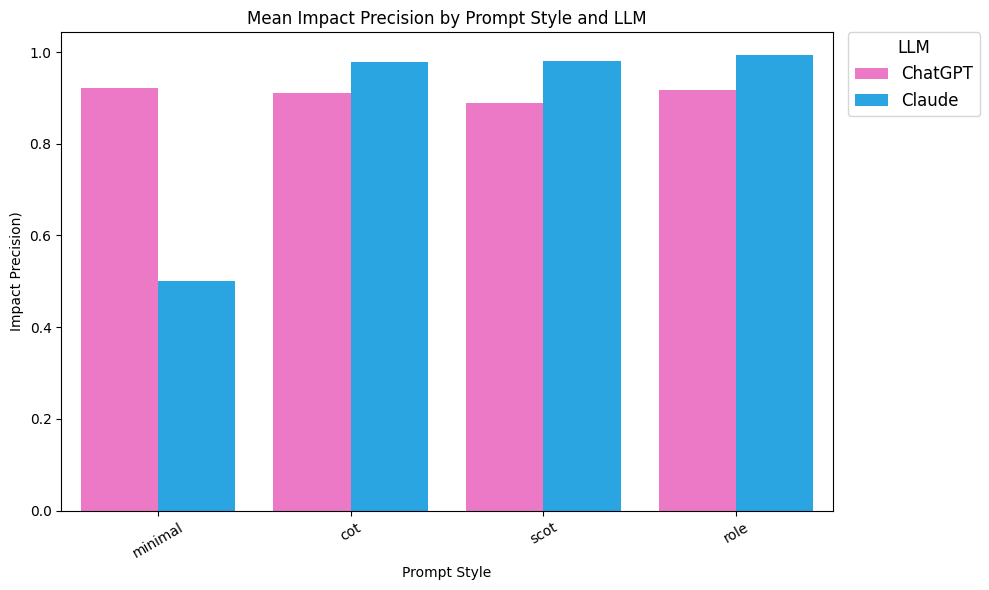

In [41]:
# impact precision
plt.errorbar(
    df["prec_median"],
    df["experiment_id"],
    xerr=[df["prec_median"] - df["prec_lower"], df["prec_upper"] - df["prec_median"]],
    fmt='s',
    color='black',
    ecolor='gray',
    elinewidth=1.5,
    capsize=4
)
plt.axvline(0.5, color='red', linestyle='--', label='Chance Level')

plt.xlabel("Impact Precision")
plt.ylabel("Experiment ID")
plt.title("Impact Precision with 95% Confidence Intervals")
plt.gca().invert_yaxis()
plt.legend(loc='upper left')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# mean precision


plt.figure(figsize=(10,6))
sns.barplot(
    data=df, x="prompt_style", y="precision_impact", hue='LLM', palette=LLM_COLORS,
    ci="sd", estimator="mean"
)
plt.title("Mean Impact Precision by Prompt Style and LLM")
plt.ylabel("Impact Precision)")
plt.xlabel("Prompt Style")
plt.legend(title="LLM", fontsize=12, title_fontsize=12, bbox_to_anchor=(1.02, 1), loc="upper left", borderaxespad=0)
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()


# Misc Viz

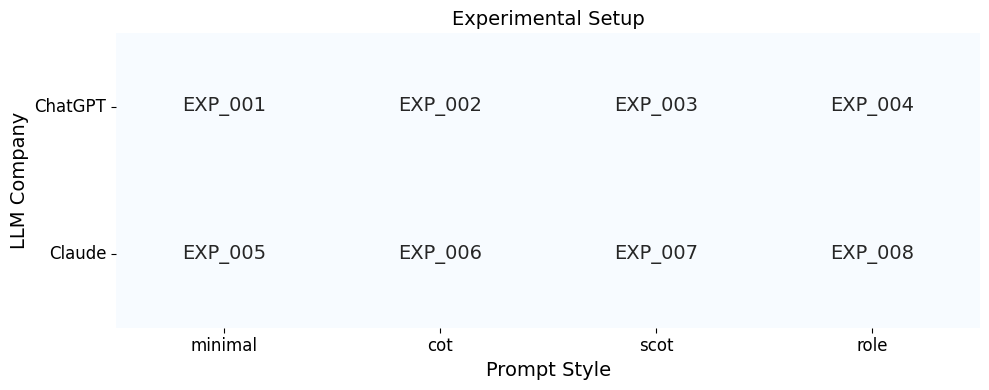

In [42]:

# Matrix

prompt_order = ["minimal", "cot", "scot", "role"]
llm_order = ["ChatGPT", "Claude"]
matrix_df = df.pivot(index='llm_company', columns='prompt_style', values='experiment_id')
matrix_df = matrix_df.reindex(index=llm_order, columns=prompt_order)

plt.figure(figsize=(10,4))

sns.heatmap(
    matrix_df.notnull(),
    annot=matrix_df,
    fmt='',
    cbar=False,
    cmap='Blues',
    annot_kws={"fontsize":14}
)

plt.title("Experimental Setup", fontsize=14)
plt.xlabel("Prompt Style", fontsize=14)
plt.ylabel("LLM Company", fontsize=14)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12, rotation=0)

plt.tight_layout()
plt.show()


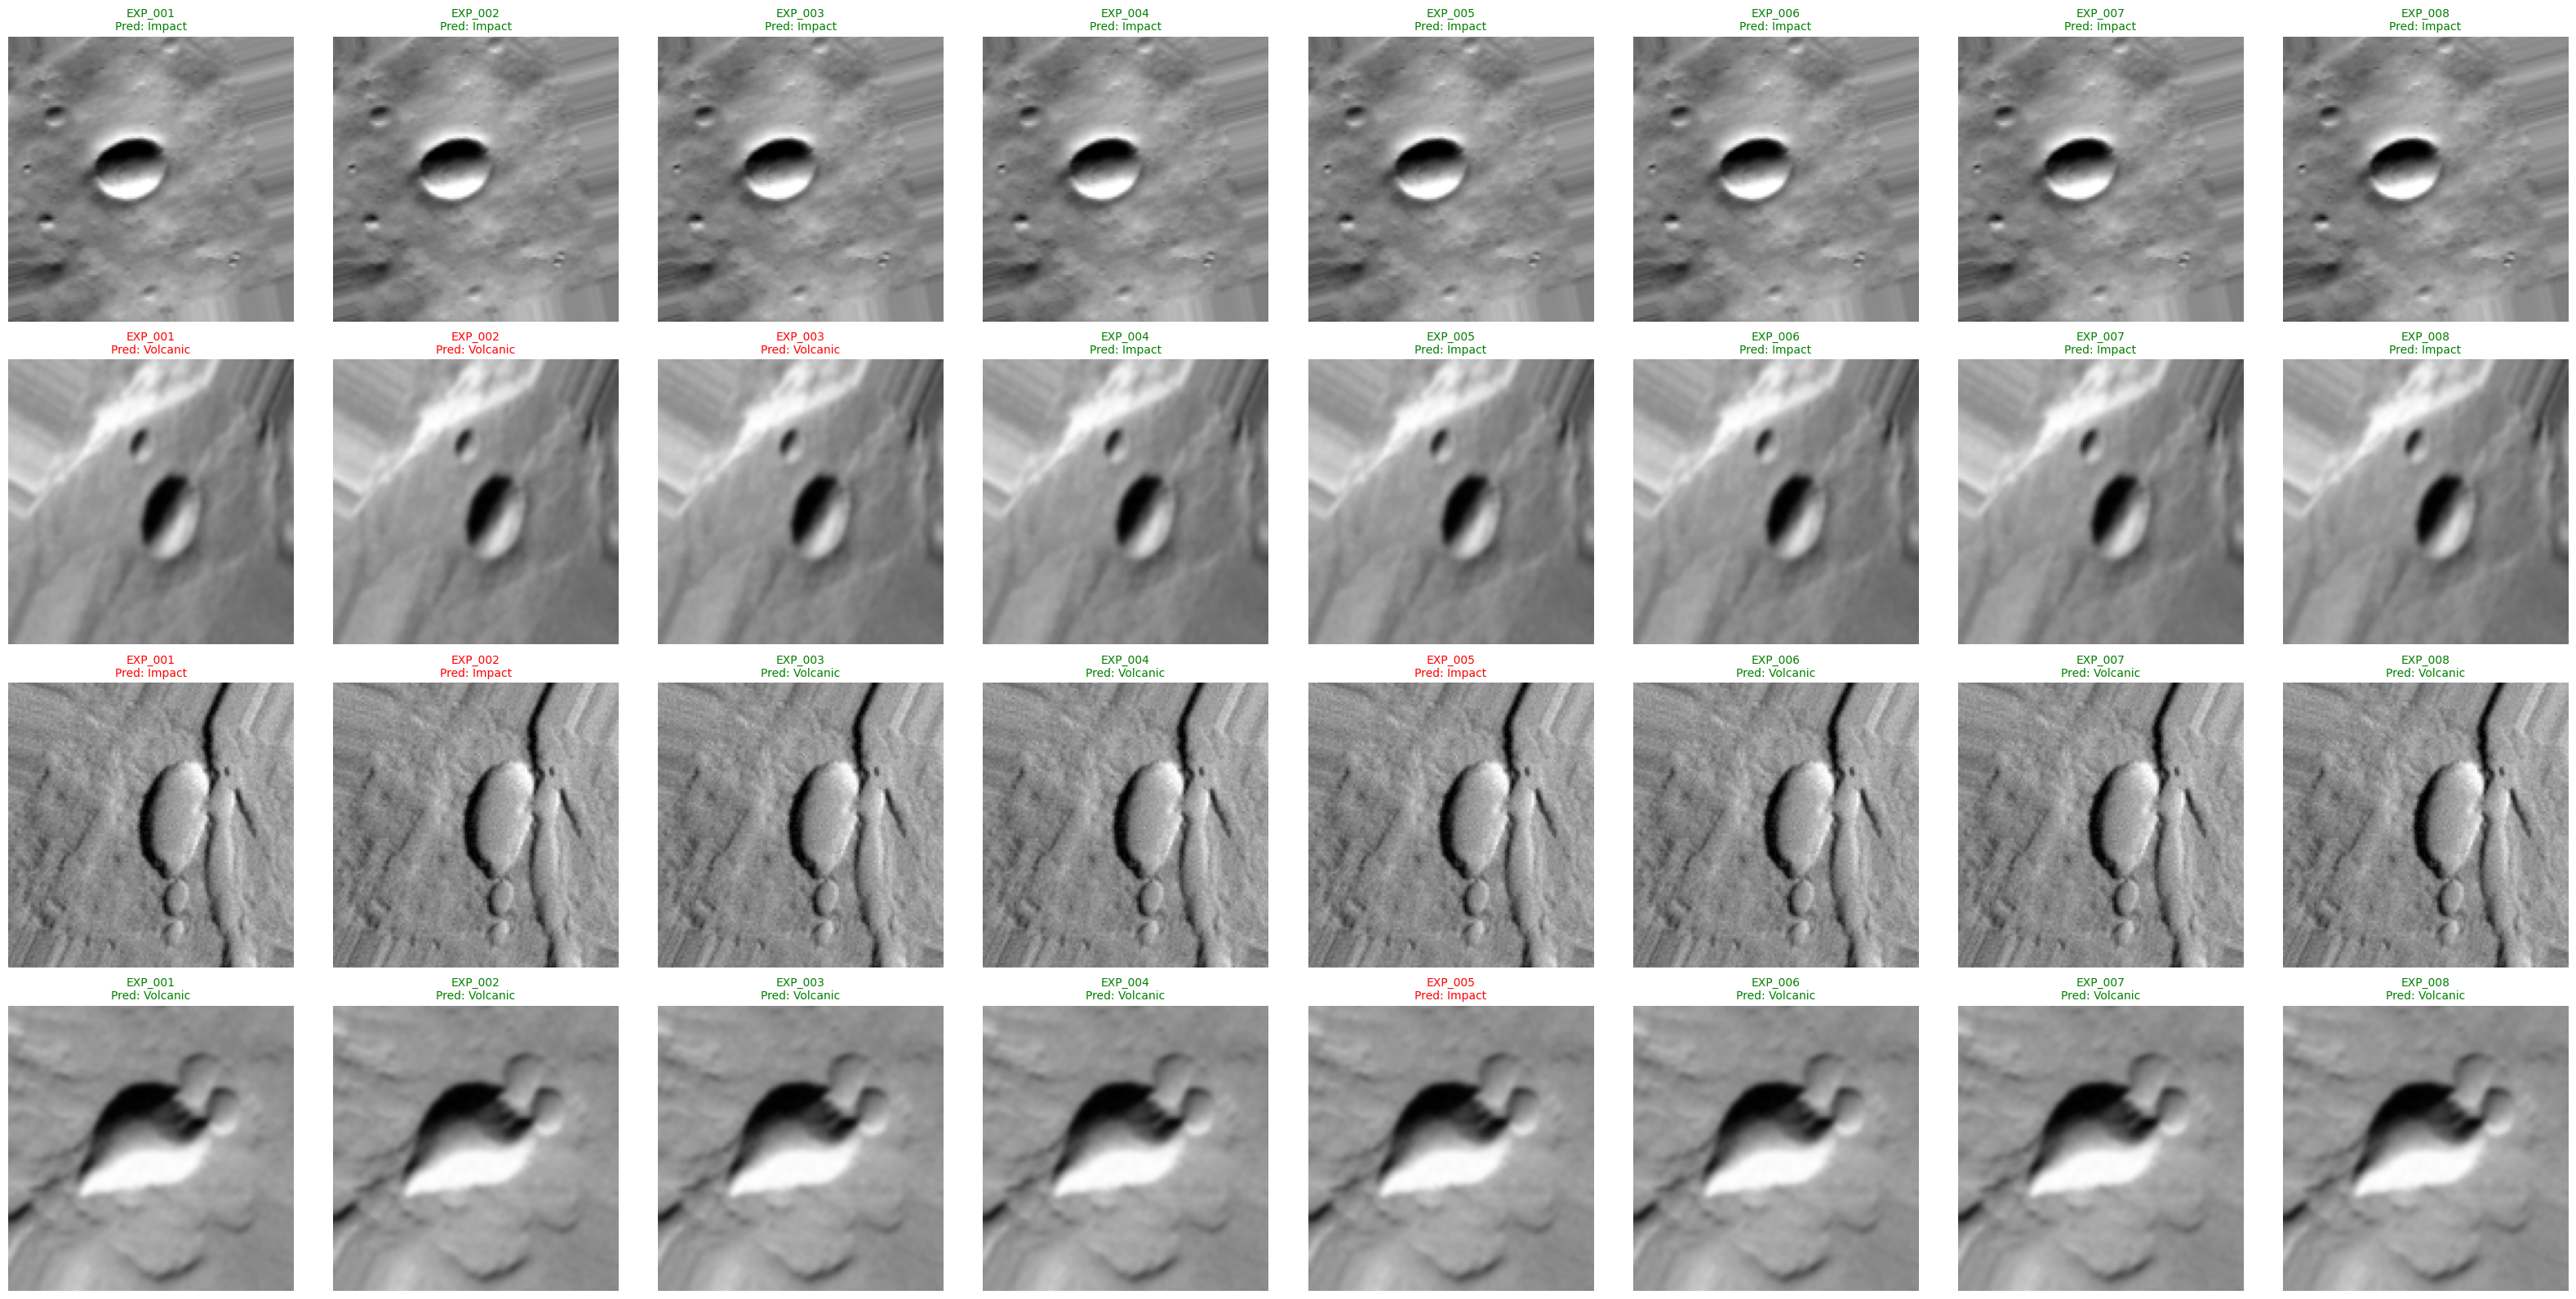

In [43]:

# Samples


y_true_all = test_gen.classes
num_samples_per_class = 2
impact_indices = np.random.choice(np.where(y_true_all == 0)[0], num_samples_per_class, replace=False)
volcanic_indices = np.random.choice(np.where(y_true_all == 1)[0], num_samples_per_class, replace=False)

sample_indices = np.concatenate([impact_indices, volcanic_indices])

def get_img_from_gen(idx, gen):
    batch_size = gen.batch_size
    batch_idx = idx // batch_size
    img_idx = idx % batch_size
    x_batch, _ = gen[batch_idx]
    return x_batch[img_idx]

imgs = np.array([get_img_from_gen(i, test_gen) for i in sample_indices])
true_labels = y_true_all[sample_indices]

fig, axes = plt.subplots(len(sample_indices), len(models), figsize=(4*len(models), 4*len(sample_indices)))

if len(models) == 1:
    axes = np.expand_dims(axes, axis=1)

for i, idx in enumerate(sample_indices):
    for j, (name, res) in enumerate(results.items()):
        ax = axes[i, j]
        img = np.squeeze(imgs[i])
        ax.imshow(img, cmap='gray')
        ax.axis('off')

        pred_label = res['y_pred'][idx]
        color = 'green' if pred_label == true_labels[i] else 'red'
        label_text = f"{name}\nPred: {'Impact' if pred_label==0 else 'Volcanic'}"
        ax.set_title(label_text, color=color, fontsize=10)

plt.tight_layout()
plt.show()


# Layer Analysis

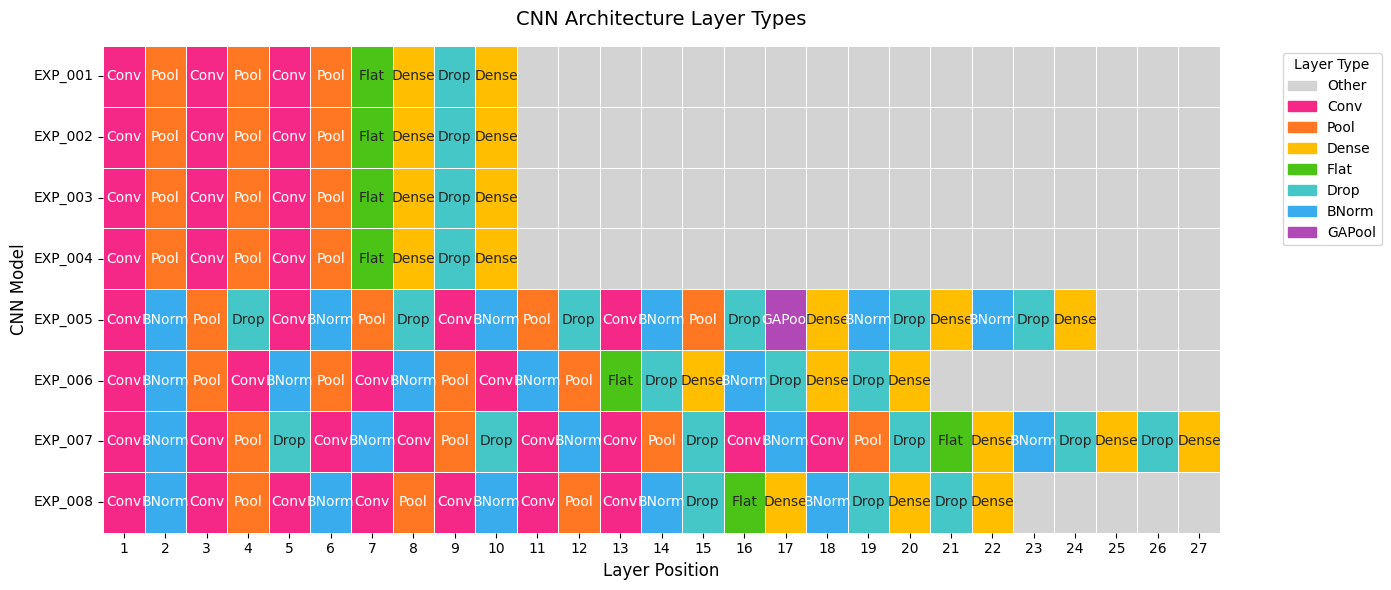

In [44]:

# Map all layers
layer_type_map = {
    "Conv2D": 1,
    "MaxPooling2D": 2,
    "Dense": 3,
    "Flatten": 4,
    "Dropout": 5,
    "BatchNormalization": 6,
    "GlobalAveragePooling2D": 7
}

layer_labels = {
    1: "Conv",
    2: "Pool",
    3: "Dense",
    4: "Flat",
    5: "Drop",
    6: "BNorm",
    7: "GAPool"
}

#  Build matrix
max_layers = max(len(model.layers) for model in models)
layer_matrix = np.zeros((len(models), max_layers), dtype=int)
label_matrix = np.full((len(models), max_layers), "", dtype=object)

for i, model in enumerate(models):
    for j, layer in enumerate(model.layers):
        code = layer_type_map.get(layer.__class__.__name__, 0)  # 0 if not mapped
        layer_matrix[i, j] = code
        label_matrix[i, j] = layer_labels.get(code, "")  # blank for unmapped

# colours
custom_colors = {
    0: "lightgray",  # unused/unmapped
    1: "#F52887",   # pink - Conv
    2: "#ff7722",   # orange - Pool
    3: "#FFBF00",   # yellow - Dense
    4: "#4cc417",   # green - Flatten
    5: "#46c7c7",   # teal - Dropout
    6: "#38acec",   # blue - BatchNorm
    7: "#b048b5"    # purple - GAPool
}

cmap = sns.color_palette([custom_colors[k] for k in sorted(custom_colors.keys())])

plt.figure(figsize=(14, 6))
ax = sns.heatmap(
    layer_matrix,
    cmap=cmap,
    cbar=False,
    linewidths=0.5,
    linecolor="white",
    annot=label_matrix,
    fmt="",
    xticklabels=range(1, max_layers+1),
    yticklabels=model_names
)

plt.xlabel("Layer Position", fontsize=12)
plt.ylabel("CNN Model", fontsize=12)
plt.title("CNN Architecture Layer Types", fontsize=14, pad=15)
handles = [
    mpatches.Patch(color=custom_colors[i], label=layer_labels.get(i, "Other"))
    for i in sorted(custom_colors.keys())
]
plt.legend(handles=handles, bbox_to_anchor=(1.05, 1), loc="upper left", title="Layer Type")

plt.tight_layout()
plt.show()


<Figure size 1200x600 with 0 Axes>

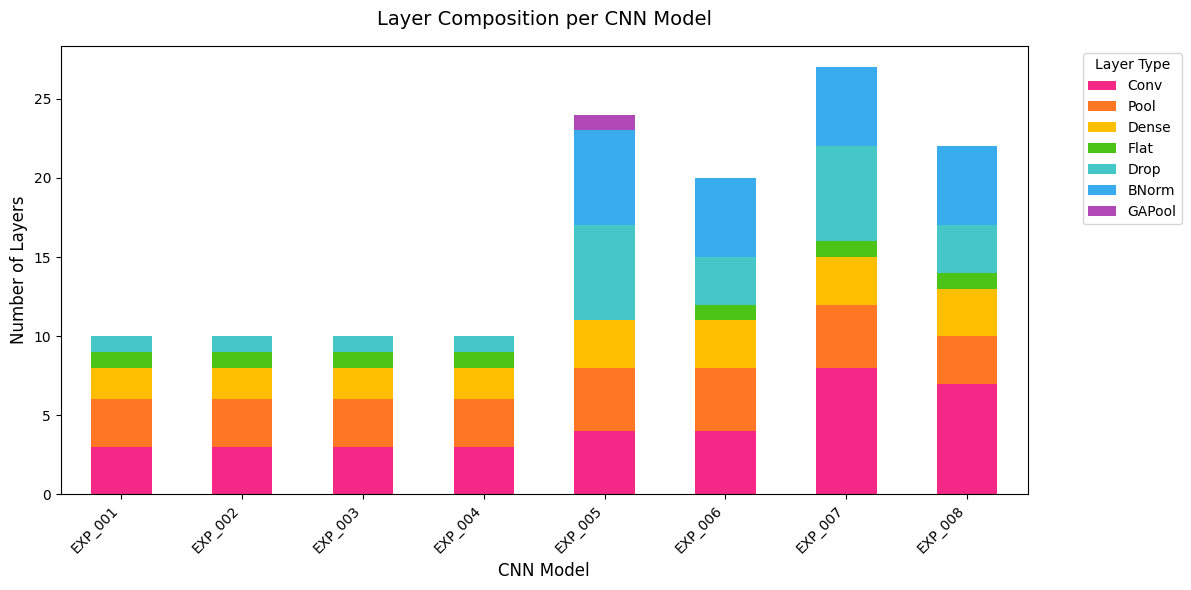

In [45]:


# bar version
layer_labels = {
    1: "Conv",
    2: "Pool",
    3: "Dense",
    4: "Flat",
    5: "Drop",
    6: "BNorm",
    7: "GAPool"
}
custom_colors = {
    "Conv": "#F52887",
    "Pool": "#ff7722",
    "Dense": "#FFBF00",
    "Flat": "#4cc417",
    "Drop": "#46c7c7",
    "BNorm": "#38acec",
    "GAPool": "#b048b5"
}

# Build a DataFrame counting each layer type per model
arch_df = pd.DataFrame(0, index=model_names, columns=layer_labels.values())

for i, labels in enumerate(label_matrix):
    for lbl in labels:
        if lbl in arch_df.columns:
            arch_df.at[model_names[i], lbl] += 1

plt.figure(figsize=(12,6))
ax = arch_df.plot(
    kind="bar",
    stacked=True,
    color=[custom_colors[col] for col in arch_df.columns],
    figsize=(12,6)
)

plt.title("Layer Composition per CNN Model", fontsize=14, pad=15)
plt.ylabel("Number of Layers", fontsize=12)
plt.xlabel("CNN Model", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title="Layer Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()





# Time

In [47]:
# Manual times -> seconds
time_map = {
    "EXP_001": 29*60 + 10,       # 29m 10s
    "EXP_002": 28*60 + 15,       # 28m 15s
    "EXP_003": 55*60 + 30,       # 55m 30s
    "EXP_004": 50*60 + 50,       # 50m 50s
    "EXP_005": 38*60 + 45,       # 38m 45s
    "EXP_006": 15*60 + 20,       # 15m 20s
    "EXP_007": 3*3600 + 52*60 + 40,   # 3h 52m 40s
    "EXP_008": 3*3600 + 45*60 + 20,   # 3h 45m 20s
}

df["train_time_s"] = df["experiment_id"].map(time_map)

df["train_time_str"] = df["train_time_s"].apply(
    lambda t: f"{t//3600:d}h {(t%3600)//60:02d}m {t%60:02d}s" if t >= 3600
    else f"{t//60:02d}m {t%60:02d}s"
)
df

experiment_id prompt_style llm_company      llm_version        class  \
0       EXP_001      minimal     ChatGPT        chatgpt_4       binary   
1       EXP_002          cot     ChatGPT        chatgpt_4       binary   
2       EXP_003         scot     ChatGPT        chatgpt_4       binary   
3       EXP_004         role     ChatGPT        chatgpt_4       binary   
4       EXP_005      minimal      Claude  claude_sonnet_4  categorical   
5       EXP_006          cot      Claude  claude_sonnet_4       binary   
6       EXP_007         scot      Claude  claude_sonnet_4       binary   
7       EXP_008         role      Claude  claude_sonnet_4       binary   

       LLM   Prompt  train_accuracy  train_loss  val_accuracy  ...  LLM_label  \
0  ChatGPT  Minimal        0.983750    0.052600      0.893333  ...        NaN   
1  ChatGPT      CoT        0.988750    0.031840      0.900000  ...        NaN   
2  ChatGPT     sCoT        0.920000    0.212335      0.866667  ...        NaN   
3  ChatGPT     Role        0.941667    0.168509      0.953333  ...        NaN   
4   Claude  Minimal        0.846875    0.371062      0.518750  ...        NaN   
5   Claude      CoT        0.961667    0.113068      0.972222  ...        NaN   
6   Claude     sCoT        0.962917    0.111482      0.983333  ...        NaN   
7   Claude     Role        0.987083    0.040376      1.000000  ...        NaN   

   layers      params epochs precision_impact prec_lower prec_median  \
0    10.0   3304193.0   15.0         0.921986   0.874978    0.923611   
1    10.0   3304193.0   17.0         0.910959   0.861835    0.912285   
2    10.0   3304193.0   30.0         0.888889   0.833333    0.889571   
3    10.0   3304193.0   25.0         0.917808   0.871617    0.918443   
4    24.0    656258.0   11.0         0.500000   0.436667    0.500000   
5    20.0   5176705.0   30.0         0.978723   0.953122    0.979730   
6    27.0   9696353.0   41.0         0.979452   0.954190    0.979730   
7    22.0  13759073.0   50.0         0.993289   0.979167    0.993399   

   prec_upper  train_time_s  train_time_str  
0    0.962976          1750         29m 10s  
1    0.953642          1695         28m 15s  
2    0.936761          3330         55m 30s  
3    0.959184          3050         50m 50s  
4    0.553333          2325         38m 45s  
5    1.000000           920         15m 20s  
6    1.000000         13960      3h 52m 40s  
7    1.000000         13520      3h 45m 20s  

[8 rows x 35 columns]

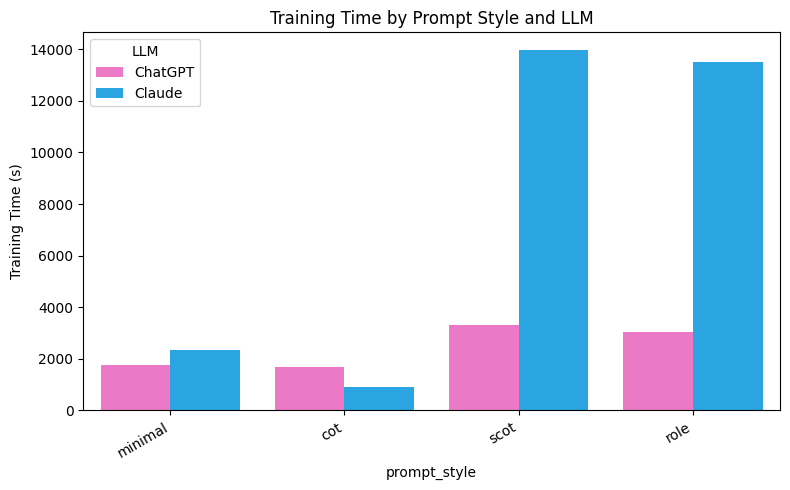

In [48]:

# bar


plt.figure(figsize=(8,5))
sns.barplot(data=df, x="prompt_style", y="train_time_s", hue="LLM", palette=LLM_COLORS)
plt.ylabel("Training Time (s)")
plt.title("Training Time by Prompt Style and LLM")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()


